**TO DO:**
 - Add relevant PCA in here? Or, just update to the new "candidate_info" file for PCA analysis
 - Add in population to return metrics? [PROBABLY]
 - Tune model
 - Modify data columns?
 - Do predictions for both Test & Validation (once making no more changes) [keep SD the same?]
 - Try dropping old years for training, like 2010?
 - Normalize figures to 100% of vote?
 - Get our error calcs down by:
    - Removing some of the candidates?
    - Adding a number of candidates metric?
    - Normalizing figures?
    - Modify probability for candidates at 0% to <1% label?
 - Export PCA MODEL?
    -> Both ability to model as well as to predict

**IMPORT PACKAGES**

In [1]:
# !pip install us --upgrade
# !pip install prettytable

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib #for fuller functionality, incl. colors
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
import pandas as pd
from IPython.display import display
import math
from us import states as us_states

from sklearn import mixture

# Remove Deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# for nicer printing
from prettytable import PrettyTable

#increase number of columns can see in pandas
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 500)

**LOAD CANDIDATE INFO INTO DATA FRAME**

In [3]:
df_candidates = pd.DataFrame.from_csv("text_files/candidate_info.csv")

#rename state_abbr to state
df_candidates.rename(columns={'state_abbr':'state'}, inplace=True)

#add concatentates for matching purposes
df_candidates['candidate_year'] = df_candidates['candidate'] +"_"+ df_candidates['year'].map(str)

display(df_candidates.head(5))

,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year
0,Al Franken,Al_Franken,2014,Al_Franken_2014,1052794,MN,http://www.ontheissues.org/Senate/Al_Franken.htm,1052794.0,1980016,1,53.2%,-5.0,-3.0,-5.0,-2.0,-5.0,-5.0,-3.0,-2.0,-2.0,-5.0,-5.0,-5.0,-3.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,Al Franken_2014
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.6%,-5.0,5.0,-5.0,-5.0,5.0,2.0,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-3.0,-2.0,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016
2,Alexander Pires,Alex_Pires,2012,Alex_Pires_2012,265374,DE,http://www.ontheissues.org/Senate/Alex_Pires.htm,15300.0,399559,0,3.8%,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-3.0,NaN,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,Alexander Pires_2012
3,Alexander Giannoulias,Alexi_Giannoulias,2010,Alexi_Giannoulias_2010,1778698,IL,http://www.ontheissues.org/Senate/Alexi_Gianno...,1719478.0,3703901,0,46.4%,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-3.0,NaN,0.0,-5.0,-3.0,-5.0,-3.0,-5.0,3.0,NaN,-2.0,-5.0,0.0,5.0,Alexander Giannoulias_2010
4,Alison Lundergan Grimes,Alison_Grimes,2014,Alison_Grimes_2014,806795,KY,http://www.ontheissues.org/Senate/Alison_Grime...,584699.0,1435734,0,40.7%,-5.0,-5.0,-5.0,0.0,-5.0,-3.0,-3.0,3.0,3.0,2.0,-3.0,-2.0,-3.0,0.0,3.0,-2.0,-2.0,2.0,-2.0,-5.0,Alison Lundergan Grimes_2014


In [4]:
#LOAD AND SHOW QUESTION MAPPING
df_names = pd.DataFrame.from_csv("text_files/issue_number_mapper.csv")
print "QUESTION MAP"
# display(df_names)
x = df_names.to_json(orient='records')

QUESTION MAP


In [5]:
# for i in x.values:
#     print i

**LOAD HISTORICAL SENATORS INFO**

In [6]:
df_hist_sen = pd.DataFrame.from_csv("text_files/historical_senators_ontheissues_info.csv")
df_hist_sen['current_senator'] = 1
#is actually matching to subsequent senate year; bringing in to see if were in prior senate (incumbent), same name makes this easier for merge
df_hist_sen['full_name_year'] = df_hist_sen['full_name']+"_"+df_hist_sen['next_senate_year'].map(str)

#fix mislabelings
df_hist_sen['party'][df_hist_sen['full_name']=="Al_Franken"] = "D"
df_hist_sen['party'][df_hist_sen['full_name']=="Martin_Heinrich"] = "D"
df_hist_sen['party'][df_hist_sen['full_name']=="Mike_Rounds"] = "R"

display(df_hist_sen)


C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,full_name,first_name,last_name,party,state,url,year,next_senate_year,reelection_year,current_senator,full_name_year
0,Richard_Shelby,Richard,Shelby,R,AL,http://www.ontheissues.org/Senate/Richard_Shel...,2016,2018,2022,1,Richard_Shelby_2018
1,Jeff_Sessions,Jeff,Sessions,R,AL,http://www.ontheissues.org/Senate/Jeff_Session...,2016,2018,2022,1,Jeff_Sessions_2018
2,Lisa_Murkowski,Lisa,Murkowski,I,AK,http://www.ontheissues.org/Senate/Lisa_Murkows...,2016,2018,2022,1,Lisa_Murkowski_2018
3,Dan_Sullivan,Dan,Sullivan,R,AK,http://www.ontheissues.org/Senate/Dan_Sullivan...,2016,2018,2022,1,Dan_Sullivan_2018
4,John_McCain,John,McCain,R,AZ,http://www.ontheissues.org/Senate/John_McCain.htm,2016,2018,2022,1,John_McCain_2018
5,Jeff_Flake,Jeff,Flake,R,AZ,http://www.ontheissues.org/Senate/Jeff_Flake.htm,2016,2018,2022,1,Jeff_Flake_2018
6,John_Boozman,John,Boozman,R,AR,http://www.ontheissues.org/Senate/John_Boozman...,2016,2018,2022,1,John_Boozman_2018
7,Tom_Cotton,Tom,Cotton,R,AR,http://www.ontheissues.org/Senate/Tom_Cotton.htm,2016,2018,2022,1,Tom_Cotton_2018
8,Dianne_Feinstein,Dianne,Feinstein,D,CA,http://www.ontheissues.org/Senate/Dianne_Feins...,2016,2018,2022,1,Dianne_Feinstein_2018
9,Barbara_Boxer,Barbara,Boxer,D,CA,http://www.ontheissues.org/Senate/Barbara_Boxe...,2016,2018,2022,1,Barbara_Boxer_2018


**MERGE INCUMBENCY**

In [7]:
### MERGE INFO
df_candidates = pd.merge(df_candidates,
                 df_hist_sen[['full_name_year', 'current_senator']],
                 on='full_name_year',
              how='left')

#RENAME TO MORE RELEVANT NAME
df_candidates.rename(columns={'current_senator':'incumbent'}, inplace=True)
    

display(df_candidates.head())

,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent
0,Al Franken,Al_Franken,2014,Al_Franken_2014,1052794,MN,http://www.ontheissues.org/Senate/Al_Franken.htm,1052794.0,1980016,1,53.2%,-5.0,-3.0,-5.0,-2.0,-5.0,-5.0,-3.0,-2.0,-2.0,-5.0,-5.0,-5.0,-3.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,Al Franken_2014,1.0
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.6%,-5.0,5.0,-5.0,-5.0,5.0,2.0,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-3.0,-2.0,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,NaN
2,Alexander Pires,Alex_Pires,2012,Alex_Pires_2012,265374,DE,http://www.ontheissues.org/Senate/Alex_Pires.htm,15300.0,399559,0,3.8%,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-3.0,NaN,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,Alexander Pires_2012,NaN
3,Alexander Giannoulias,Alexi_Giannoulias,2010,Alexi_Giannoulias_2010,1778698,IL,http://www.ontheissues.org/Senate/Alexi_Gianno...,1719478.0,3703901,0,46.4%,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-3.0,NaN,0.0,-5.0,-3.0,-5.0,-3.0,-5.0,3.0,NaN,-2.0,-5.0,0.0,5.0,Alexander Giannoulias_2010,NaN
4,Alison Lundergan Grimes,Alison_Grimes,2014,Alison_Grimes_2014,806795,KY,http://www.ontheissues.org/Senate/Alison_Grime...,584699.0,1435734,0,40.7%,-5.0,-5.0,-5.0,0.0,-5.0,-3.0,-3.0,3.0,3.0,2.0,-3.0,-2.0,-3.0,0.0,3.0,-2.0,-2.0,2.0,-2.0,-5.0,Alison Lundergan Grimes_2014,NaN


**REPLACE INCOSISNTENT TREATMENT OF SUPPORT / DO NOT SUPPORT (3's and 2's to 2.5's). Also Fill NaN with 0**

In [8]:
### CONSIDER UNDO-ING... SEEMS LIKE THERE IS A PATTERN WHETHER -2 vs -3 on social vs economic questions. Could always apply the same.

df_candidates['1'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['2'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['3'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['4'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['5'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['6'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['7'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['8'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['9'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['10'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['11'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['12'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['13'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['14'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['15'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['16'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['17'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['18'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['19'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)
df_candidates['20'].replace([-2,-3,2,3],[-2.5,-2.5,2.5,2.5],inplace=True)


df_candidates = df_candidates.fillna(0)

display(df_candidates.head())

,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent
0,Al Franken,Al_Franken,2014,Al_Franken_2014,1052794,MN,http://www.ontheissues.org/Senate/Al_Franken.htm,1052794.0,1980016,1,53.2%,-5.0,-2.5,-5.0,-2.5,-5.0,-5.0,-2.5,-2.5,-2.5,-5.0,-5.0,-5.0,-2.5,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,Al Franken_2014,1.0
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.6%,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,0.0
2,Alexander Pires,Alex_Pires,2012,Alex_Pires_2012,265374,DE,http://www.ontheissues.org/Senate/Alex_Pires.htm,15300.0,399559,0,3.8%,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,0.0,0.0,0.0,-2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alexander Pires_2012,0.0
3,Alexander Giannoulias,Alexi_Giannoulias,2010,Alexi_Giannoulias_2010,1778698,IL,http://www.ontheissues.org/Senate/Alexi_Gianno...,1719478.0,3703901,0,46.4%,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-2.5,0.0,0.0,-5.0,-2.5,-5.0,-2.5,-5.0,2.5,0.0,-2.5,-5.0,0.0,5.0,Alexander Giannoulias_2010,0.0
4,Alison Lundergan Grimes,Alison_Grimes,2014,Alison_Grimes_2014,806795,KY,http://www.ontheissues.org/Senate/Alison_Grime...,584699.0,1435734,0,40.7%,-5.0,-5.0,-5.0,0.0,-5.0,-2.5,-2.5,2.5,2.5,2.5,-2.5,-2.5,-2.5,0.0,2.5,-2.5,-2.5,2.5,-2.5,-5.0,Alison Lundergan Grimes_2014,0.0


**ADD SOCIAL-ECONOMIC INTO DATAFRAME**

In [9]:
#add columns for reference
## However, don't add into MODEL; surprisingly, makes model worse

df_candidates['social'] = (df_candidates['1'] + df_candidates['3'] + df_candidates['4'] + df_candidates['8'] + df_candidates['9']
                           + df_candidates['12'] + df_candidates['15'] + df_candidates['16'] + df_candidates['17'] + df_candidates['19'])

df_candidates['economic'] = (df_candidates['2'] + df_candidates['5'] + df_candidates['6'] + df_candidates['7'] + df_candidates['10']
                             + df_candidates['11'] + df_candidates['13'] + df_candidates['14'] + df_candidates['18'] + df_candidates['20'])

display(df_candidates.head())

,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic
0,Al Franken,Al_Franken,2014,Al_Franken_2014,1052794,MN,http://www.ontheissues.org/Senate/Al_Franken.htm,1052794.0,1980016,1,53.2%,-5.0,-2.5,-5.0,-2.5,-5.0,-5.0,-2.5,-2.5,-2.5,-5.0,-5.0,-5.0,-2.5,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,Al Franken_2014,1.0,-42.5,-42.5
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.6%,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,0.0,-37.5,40.0
2,Alexander Pires,Alex_Pires,2012,Alex_Pires_2012,265374,DE,http://www.ontheissues.org/Senate/Alex_Pires.htm,15300.0,399559,0,3.8%,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,0.0,0.0,0.0,-2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alexander Pires_2012,0.0,-10.0,-15.0
3,Alexander Giannoulias,Alexi_Giannoulias,2010,Alexi_Giannoulias_2010,1778698,IL,http://www.ontheissues.org/Senate/Alexi_Gianno...,1719478.0,3703901,0,46.4%,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-2.5,0.0,0.0,-5.0,-2.5,-5.0,-2.5,-5.0,2.5,0.0,-2.5,-5.0,0.0,5.0,Alexander Giannoulias_2010,0.0,-20.0,-32.5
4,Alison Lundergan Grimes,Alison_Grimes,2014,Alison_Grimes_2014,806795,KY,http://www.ontheissues.org/Senate/Alison_Grime...,584699.0,1435734,0,40.7%,-5.0,-5.0,-5.0,0.0,-5.0,-2.5,-2.5,2.5,2.5,2.5,-2.5,-2.5,-2.5,0.0,2.5,-2.5,-2.5,2.5,-2.5,-5.0,Alison Lundergan Grimes_2014,0.0,-12.5,-20.0


**LOAD PARTY INFO**

In [10]:
df_parties = pd.DataFrame.from_csv('text_files/senate_results_by_state.csv')

party_map = {
    'REP':'R',
    'GOP':'R',
    'DEM':'D',
    'IND':'I',
    'LIB':'L',
}

def assign_party_abbrev(party) :
    try :
        party_abbrev = party_map[party]
        return party_abbrev
    except :
        return "OTH"
    
df_parties['party_abbrev'] = df_parties['party'].apply(assign_party_abbrev)

#add concatentates for matching purposes
df_parties['candidate_year'] = df_parties['candidate'] +"_"+ df_parties['year'].map(str)


display(df_parties.head())

,state_abbr,year,candidate,party,votes_total,party_abbrev,candidate_year
1,AL,2010,Richard Shelby,REP,968181.0,R,Richard Shelby_2010
2,AL,2010,William Barnes,DEM,515619.0,D,William Barnes_2010
3,AK,2010,Lisa Murkowski,REP,101091.0,R,Lisa Murkowski_2010
4,AK,2010,Joe Miller,REP,90860.0,R,Joe Miller_2010
5,AK,2010,Scott McAdams,DEM,60045.0,D,Scott McAdams_2010


**MERGE PARTY INFO INTO CANDIDATES DATAFRAME, LOOK FOR MISLABELED CANDIDATES AND CORRECT, MAKE PARTY CATEGORICAL TYPE**

In [11]:
### MERGE INFO
df_candidates = pd.merge(df_candidates,
                 df_parties[['candidate_year', 'party_abbrev']],
                 on='candidate_year',
              how='left')

display(df_candidates.head())

,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev
0,Al Franken,Al_Franken,2014,Al_Franken_2014,1052794,MN,http://www.ontheissues.org/Senate/Al_Franken.htm,1052794.0,1980016,1,53.2%,-5.0,-2.5,-5.0,-2.5,-5.0,-5.0,-2.5,-2.5,-2.5,-5.0,-5.0,-5.0,-2.5,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,Al Franken_2014,1.0,-42.5,-42.5,D
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.6%,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,0.0,-37.5,40.0,L
2,Alexander Pires,Alex_Pires,2012,Alex_Pires_2012,265374,DE,http://www.ontheissues.org/Senate/Alex_Pires.htm,15300.0,399559,0,3.8%,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,0.0,0.0,0.0,-2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alexander Pires_2012,0.0,-10.0,-15.0,OTH
3,Alexander Giannoulias,Alexi_Giannoulias,2010,Alexi_Giannoulias_2010,1778698,IL,http://www.ontheissues.org/Senate/Alexi_Gianno...,1719478.0,3703901,0,46.4%,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-2.5,0.0,0.0,-5.0,-2.5,-5.0,-2.5,-5.0,2.5,0.0,-2.5,-5.0,0.0,5.0,Alexander Giannoulias_2010,0.0,-20.0,-32.5,D
4,Alison Lundergan Grimes,Alison_Grimes,2014,Alison_Grimes_2014,806795,KY,http://www.ontheissues.org/Senate/Alison_Grime...,584699.0,1435734,0,40.7%,-5.0,-5.0,-5.0,0.0,-5.0,-2.5,-2.5,2.5,2.5,2.5,-2.5,-2.5,-2.5,0.0,2.5,-2.5,-2.5,2.5,-2.5,-5.0,Alison Lundergan Grimes_2014,0.0,-12.5,-20.0,D


In [12]:
# Look for mislabels
## --> (there are none)

print "DEM LABEL"
display(df_candidates[(df_candidates['social']>0)&(df_candidates['economic']>0)&(df_candidates['party_abbrev']=="D")])
display(df_candidates[(df_candidates['social']>10)&(df_candidates['party_abbrev']=="D")])
display(df_candidates[(df_candidates['economic']>10)&(df_candidates['party_abbrev']=="D")])
print 
print "REP LABEL"
display(df_candidates[(df_candidates['social']<0)&(df_candidates['economic']<0)&(df_candidates['party_abbrev']=="R")])
display(df_candidates[(df_candidates['social']<10)&(df_candidates['party_abbrev']=="R")])
display(df_candidates[(df_candidates['economic']<10)&(df_candidates['party_abbrev']=="R")])

DEM LABEL


,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev


,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev
96,Jack Conway,Jack_Conway,2010,Jack_Conway_2010,755411,KY,http://www.ontheissues.org/Senate/Jack_Conway.htm,599843.0,1356468,0,44.2%,-2.5,-5.0,0.0,0.0,-5.0,-5.0,2.5,0.0,2.5,5.0,5.0,5.0,-2.5,0.0,2.5,0.0,5.0,2.5,5.0,0.0,Jack Conway_2010,0.0,17.5,-2.5,D
116,Joe Donnelly,Joe_Donnelly,2012,Joe_Donnelly_2012,1268407,IN,http://www.ontheissues.org/Senate/Joe_Donnelly...,1268407.0,2541692,1,49.9%,5.0,-5.0,2.5,0.0,-5.0,-5.0,-5.0,-2.5,-2.5,5.0,-2.5,5.0,-5.0,-2.5,2.5,-5.0,2.5,-2.5,5.0,-2.5,Joe Donnelly_2012,0.0,12.5,-30.0,D
300,Travis Childers,Travis_Childers,2014,Travis_Childers_2014,370208,MS,http://www.ontheissues.org/Senate/Travis_Child...,228974.0,612842,0,37.4%,5.0,0.0,5.0,2.5,-5.0,-5.0,-2.5,0.0,0.0,5.0,2.5,5.0,-5.0,0.0,0.0,-2.5,0.0,-2.5,2.5,-5.0,Travis Childers_2014,0.0,17.5,-17.5,D


,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev



REP LABEL


,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev
142,Joseph Cao,Joseph_Cao,2016,Joseph_Cao_2016,482380,LA,http://www.ontheissues.org/Senate/Joseph_Cao.htm,21011.0,1932481,0,1.1%,2.5,0.0,-2.5,0.0,-2.5,0.0,-2.5,-2.5,2.5,-2.5,0.0,-5.0,0.0,0.0,0.0,-2.5,2.5,0.0,0.0,-5.0,Joseph Cao_2016,0.0,-5.0,-12.5,R


,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev
16,Barry Hinckley,Barry_Hinckley,2012,Barry_Hinckley_2012,265687,RI,http://www.ontheissues.org/Senate/Barry_Hinckl...,144620.0,410307,0,35.2%,-2.5,0.0,-5.0,0.0,5.0,2.5,5.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,-5.0,5.0,0.0,-2.5,Barry Hinckley_2012,0.0,-7.5,25.0,R
28,Brian Herr,Brian_Herr,2014,Brian_Herr_2014,1285736,MA,http://www.ontheissues.org/Senate/Brian_Herr.htm,789378.0,2075114,0,38.0%,-5.0,0.0,-5.0,0.0,5.0,0.0,2.5,0.0,0.0,5.0,2.5,2.5,0.0,-2.5,2.5,-5.0,-2.5,0.0,0.0,5.0,Brian Herr_2014,0.0,-12.5,17.5,R
46,Chris Vance,Chris_Vance,2016,Chris_Vance_2016,1765333,WA,http://www.ontheissues.org/Senate/Chris_Vance.htm,1220755.0,2986088,0,40.9%,0.0,0.0,-2.5,0.0,2.5,-2.5,5.0,-2.5,0.0,0.0,0.0,-5.0,5.0,5.0,5.0,0.0,2.5,2.5,0.0,2.5,Chris Vance_2016,0.0,-2.5,20.0,R
127,John Carroll,John_Carroll,2016,John_Carroll_2016,306543,HI,http://www.ontheissues.org/Senate/John_Carroll...,92620.0,415065,0,22.3%,5.0,0.0,-2.5,0.0,2.5,5.0,-2.5,-5.0,-5.0,0.0,5.0,2.5,5.0,-2.5,5.0,5.0,2.5,5.0,0.0,-2.5,John Carroll_2016,0.0,7.5,15.0,R
132,John MacGovern,John_MacGovern,2012,John_MacGovern_2012,208253,VT,http://www.ontheissues.org/Senate/John_MacGove...,72629.0,292744,0,24.8%,5.0,2.5,0.0,0.0,5.0,2.5,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,-2.5,5.0,0.0,0.0,John MacGovern_2012,0.0,2.5,25.0,R
133,John McCain,John_McCain,2010,John_McCain_2010,1005615,AZ,http://www.ontheissues.org/Senate/John_McCain.htm,1005615.0,1713114,1,58.7%,2.5,-2.5,-2.5,2.5,2.5,5.0,5.0,-2.5,2.5,5.0,2.5,-2.5,5.0,2.5,2.5,-5.0,5.0,-2.5,5.0,2.5,John McCain_2010,1.0,7.5,25.0,R
134,John McCain,John_McCain,2016,John_McCain_2016,1089324,AZ,http://www.ontheissues.org/Senate/John_McCain.htm,1089324.0,2041017,1,53.4%,2.5,-2.5,-2.5,2.5,2.5,5.0,5.0,-2.5,2.5,5.0,2.5,-2.5,5.0,2.5,2.5,-5.0,5.0,-2.5,5.0,2.5,John McCain_2016,1.0,7.5,25.0,R
142,Joseph Cao,Joseph_Cao,2016,Joseph_Cao_2016,482380,LA,http://www.ontheissues.org/Senate/Joseph_Cao.htm,21011.0,1932481,0,1.1%,2.5,0.0,-2.5,0.0,-2.5,0.0,-2.5,-2.5,2.5,-2.5,0.0,-5.0,0.0,0.0,0.0,-2.5,2.5,0.0,0.0,-5.0,Joseph Cao_2016,0.0,-5.0,-12.5,R
155,Kurt Bills,Kurt_Bills,2012,Kurt_Bills_2012,1856196,MN,http://www.ontheissues.org/Senate/Kurt_Bills.htm,868977.0,2843400,0,30.6%,5.0,0.0,2.5,0.0,5.0,2.5,0.0,0.0,0.0,2.5,5.0,0.0,2.5,0.0,5.0,0.0,-5.0,-2.5,-2.5,0.0,Kurt Bills_2012,0.0,5.0,15.0,R
159,Len Britton,Len_Britton,2010,Len_Britton_2010,151281,VT,http://www.ontheissues.org/Senate/Len_Britton.htm,72699.0,229070,0,31.7%,-2.5,0.0,-2.5,0.0,5.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,2.5,0.0,-2.5,-2.5,0.0,0.0,Len Britton_2010,0.0,-5.0,12.5,R


,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev
52,Connie Mack,Connie_Mack,2012,Connie_Mack_2012,4521534,FL,http://www.ontheissues.org/Senate/Connie_Mack.htm,3457254.0,8186871,0,42.2%,2.5,2.5,2.5,2.5,2.5,2.5,-5.0,0.0,5.0,-5.0,2.5,0.0,2.5,0.0,-5.0,0.0,2.5,2.5,5.0,0.0,Connie Mack_2012,0.0,15.0,5.0,R
135,John Kennedy,John_Neely_Kennedy,2016,John_Neely_Kennedy_2016,482380,LA,http://www.ontheissues.org/Senate/John_Neely_K...,482380.0,1932481,1,25.0%,2.5,-5.0,5.0,0.0,-5.0,-2.5,-2.5,-5.0,5.0,5.0,-2.5,5.0,-5.0,5.0,5.0,-2.5,-2.5,2.5,0.0,2.5,John Kennedy_2016,0.0,12.5,-7.5,R
142,Joseph Cao,Joseph_Cao,2016,Joseph_Cao_2016,482380,LA,http://www.ontheissues.org/Senate/Joseph_Cao.htm,21011.0,1932481,0,1.1%,2.5,0.0,-2.5,0.0,-2.5,0.0,-2.5,-2.5,2.5,-2.5,0.0,-5.0,0.0,0.0,0.0,-2.5,2.5,0.0,0.0,-5.0,Joseph Cao_2016,0.0,-5.0,-12.5,R
160,Linda Lingle,Linda_Lingle,2012,Linda_Lingle_2012,266435,HI,http://www.ontheissues.org/Senate/Linda_Lingle...,159002.0,425437,0,37.4%,5.0,0.0,5.0,0.0,2.5,-2.5,-2.5,0.0,5.0,2.5,5.0,-2.5,5.0,0.0,5.0,0.0,0.0,-2.5,2.5,0.0,Linda Lingle_2012,0.0,20.0,7.5,R
277,Susan Collins,Susan_Collins,2014,Susan_Collins_2014,412211,ME,http://www.ontheissues.org/Senate/Susan_Collin...,412211.0,601864,1,68.5%,-5.0,-5.0,-5.0,2.5,-2.5,2.5,2.5,-5.0,0.0,2.5,5.0,-2.5,2.5,2.5,2.5,-2.5,5.0,-5.0,0.0,-2.5,Susan Collins_2014,1.0,-10.0,2.5,R


In [13]:
df_candidates["party_abbrev"] = df_candidates["party_abbrev"].astype('category')

#turn categorical values into binarized values : 
df_candidates = pd.DataFrame(pd.get_dummies(data=df_candidates, columns=['party_abbrev']))

display(df_candidates.head(5))

,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R
0,Al Franken,Al_Franken,2014,Al_Franken_2014,1052794,MN,http://www.ontheissues.org/Senate/Al_Franken.htm,1052794.0,1980016,1,53.2%,-5.0,-2.5,-5.0,-2.5,-5.0,-5.0,-2.5,-2.5,-2.5,-5.0,-5.0,-5.0,-2.5,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,Al Franken_2014,1.0,-42.5,-42.5,1.0,0.0,0.0,0.0,0.0
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.6%,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,0.0,-37.5,40.0,0.0,0.0,1.0,0.0,0.0
2,Alexander Pires,Alex_Pires,2012,Alex_Pires_2012,265374,DE,http://www.ontheissues.org/Senate/Alex_Pires.htm,15300.0,399559,0,3.8%,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,0.0,0.0,0.0,-2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alexander Pires_2012,0.0,-10.0,-15.0,0.0,0.0,0.0,1.0,0.0
3,Alexander Giannoulias,Alexi_Giannoulias,2010,Alexi_Giannoulias_2010,1778698,IL,http://www.ontheissues.org/Senate/Alexi_Gianno...,1719478.0,3703901,0,46.4%,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-2.5,0.0,0.0,-5.0,-2.5,-5.0,-2.5,-5.0,2.5,0.0,-2.5,-5.0,0.0,5.0,Alexander Giannoulias_2010,0.0,-20.0,-32.5,1.0,0.0,0.0,0.0,0.0
4,Alison Lundergan Grimes,Alison_Grimes,2014,Alison_Grimes_2014,806795,KY,http://www.ontheissues.org/Senate/Alison_Grime...,584699.0,1435734,0,40.7%,-5.0,-5.0,-5.0,0.0,-5.0,-2.5,-2.5,2.5,2.5,2.5,-2.5,-2.5,-2.5,0.0,2.5,-2.5,-2.5,2.5,-2.5,-5.0,Alison Lundergan Grimes_2014,0.0,-12.5,-20.0,1.0,0.0,0.0,0.0,0.0


**BUILD IN PCA MAPPING & CLUSTERING**

In [14]:
#merge scores into historical senators df based on 2016 senators
#is missing 3 senators from merge but have to leave be {'Ben_Cardin', 'Bob_Menendez', 'Jeff_Sessions'}
#is missing 4 total but going to go with for training

### MERGE INFO
df_senators_2016 = pd.merge(df_hist_sen[df_hist_sen['year']==2016],
                df_candidates[(df_candidates['year']==2012)|(df_candidates['year']==2014)|(df_candidates['year']==2016)],
                 on='full_name',
              how='inner')

len(df_senators_2016['full_name'].unique())

96

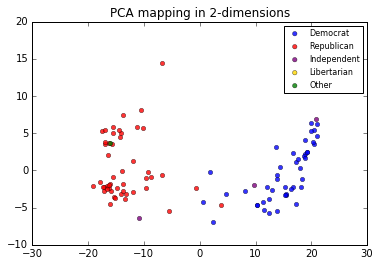

In [15]:
#fit PCA model, fit_transform the original dataset down to same number of dimensions
## based on 20 component --> 2 dimension output

#set up data frame for training
# df_scores = df_test[['1','2','3','4','5','6','7','8','9','10',
#                                              '11','12','13','14','15','16','17','18','19','20']]

#train on just the current 2016 senators

pca_model = PCA(n_components=2).fit(df_senators_2016[['1','2','3','4','5','6','7','8','9','10',
                                             '11','12','13','14','15','16','17','18','19','20']])

#transform scores into 2-dimension PCA data
scores_reduced = pca_model.transform(df_senators_2016[['1','2','3','4','5','6','7','8','9','10',
                                             '11','12','13','14','15','16','17','18','19','20']])

#add to original data frame
df_senators_2016['x_pca'] = scores_reduced[:,0]
df_senators_2016['y_pca'] = scores_reduced[:,1]

#set x-axis, y-axis for each of dem, rep, ind, lib, green parties
x_d = df_senators_2016['x_pca'][df_senators_2016['party']=="D"]
x_r = df_senators_2016['x_pca'][df_senators_2016['party']=="R"]
x_i = df_senators_2016['x_pca'][df_senators_2016['party']=="I"]
x_l = df_senators_2016['x_pca'][df_senators_2016['party']=="L"]
x_g = df_senators_2016['x_pca'][df_senators_2016['party']=="O"]

y_d = df_senators_2016['y_pca'][df_senators_2016['party']=="D"]
y_r = df_senators_2016['y_pca'][df_senators_2016['party']=="R"]
y_i = df_senators_2016['y_pca'][df_senators_2016['party']=="I"]
y_l = df_senators_2016['y_pca'][df_senators_2016['party']=="L"]
y_g = df_senators_2016['y_pca'][df_senators_2016['party']=="O"]


#self-note: good reference for setting custom legends with scatter: http://stackoverflow.com/questions/17411940/matplotlib-scatter-plot-legend

#set individual plots per party
plot_d = plt.scatter(x_d, y_d, marker='o', color='b', linewidth=0.4, edgecolor='black', alpha=0.8)
plot_r = plt.scatter(x_r, y_r, marker='o', color='r', linewidth=0.4, edgecolor='black', alpha=0.8)
plot_i = plt.scatter(x_i, y_i, marker='o', color='purple', linewidth=0.4, edgecolor='black', alpha=0.8)
plot_l = plt.scatter(x_l, y_l, marker='o', color='gold', linewidth=0.4, edgecolor='black', alpha=0.8)
plot_g = plt.scatter(x_g, y_g, marker='o', color='green', linewidth=0.4, edgecolor='black', alpha=0.8)

# plot poisonous mushrooms
# r_plot = plt.scatter(train_data_pois[:,0], train_data_pois[:,1], marker='o', color='r', linewidth=0.4, edgecolor='black', alpha=0.5)

#set up title, legend, and show plot
plt.title('PCA mapping in 2-dimensions')
plt.legend((plot_d, plot_r, plot_i, plot_l, plot_g),
           ("Democrat","Republican","Independent","Libertarian","Other"),
          scatterpoints=1,
           ncol=1,
          loc='upper right',
          fontsize=8)
plt.show()

#Check for party errors not yet fixed
# display(df_senators_2016[(df_senators_2016['x_pca']>10)&(df_senators_2016['party']=="R")])
# display(df_senators_2016[(df_senators_2016['x_pca']<0)&(df_senators_2016['party']=="D")])




TOTAL CLUSTERS: 8


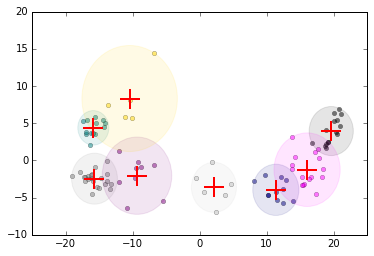

In [16]:
kmeans_max = 16

#set up 16 colors to consistently map colors to depending on cluster #
colors = ["gray","navy","black","teal","silver","purple","gold",
          "fuchsia","green","maroon","lime","olive","yellow","blue","aqua","red"]


# for num in range(kmeans_max):   #all 16
for num in [7]:                   #just 8 clusters (adds 1, and 8 seems to be the best)
    #reset matrix back to original PCA training data matrix at start of each for loop
    clusters_matrix = scores_reduced

    #set kmeans number. range starts at 0 but want kmeans to start at 1
    kmeans_num = num+1     

    #set up kmeans model, get centers, labels, distances
    kmeans_model = KMeans(n_clusters=kmeans_num, random_state=1).fit(scores_reduced)
    kmeans_centers = kmeans_model.cluster_centers_
    kmeans_labels = kmeans_model.labels_
    kmeans_distances = kmeans_model.transform(scores_reduced)  #returns matrix with distances to EACH centroid

    #add cluster labels, distances to clusters matrix
    clusters_matrix = np.insert(clusters_matrix, 2, kmeans_labels, axis=1)

    #print k-means number of total clusters
    print "\nTOTAL CLUSTERS:", kmeans_num

    #create sub-loop to plot each cluster
    for num in range(kmeans_num) :

        #add distance to new col in matrix related to centroid number
        clusters_matrix = np.insert(clusters_matrix, 3+num, kmeans_distances[:,num], axis=1)      

        #get kmeans_center for centroid
        kmeans_center_x = kmeans_centers[num][0]
        kmeans_center_y = kmeans_centers[num][1]

        #get just the subset of data belonging to cluster
        clusters_matrix_subset = clusters_matrix[clusters_matrix[:, 2] == num]

        #get max_distance of column related to distance for that centroid; later used for radius
        max_distance = np.max(clusters_matrix_subset[:,3+num])

        #plot just that cluster
        plt.scatter(clusters_matrix_subset[:,0], clusters_matrix_subset[:,1], marker='o', 
                    color=colors[num], linewidth=0.4, edgecolor='black', alpha=0.5)

        #set axes
        plt.xlim(-25, 25)
        plt.ylim(-10, 20)
        
        #plot center associated with that cluster
        plt.plot(kmeans_centers[num][0],kmeans_centers[num][1], marker='+', color='red', 
                 markersize=20, markeredgewidth=2)

        #plot circle (self-note: good reference http://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot) 
        circle = plt.Circle((kmeans_center_x, kmeans_center_y), max_distance, color=colors[num], alpha=0.1)
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_artist(circle)

    plt.show()

**ADD TO 2016 SENATORS DATA FRAME EACH FOR 8 CLUSTERS**

In [17]:
kmeans_num = 8

#set up kmeans model, get centers, labels, distances
kmeans_model = KMeans(n_clusters=kmeans_num, random_state=1).fit(scores_reduced)
kmeans_centers = kmeans_model.cluster_centers_
kmeans_labels = kmeans_model.labels_
kmeans_distances = kmeans_model.transform(scores_reduced)  #returns matrix with distances to EACH centroid

df_senators_2016['8_clusters'] = kmeans_labels

display(df_senators_2016.head())

,full_name,first_name,last_name,party,state_x,url,year_x,next_senate_year,reelection_year,current_senator,full_name_year_x,candidate,year_y,full_name_year_y,max_state,state_y,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,x_pca,y_pca,8_clusters
0,Richard_Shelby,Richard,Shelby,R,AL,http://www.ontheissues.org/Senate/Richard_Shel...,2016,2018,2022,1,Richard_Shelby_2018,Richard Shelby,2016,Richard_Shelby_2016,1323184,AL,http://www.ontheissues.org/Senate/Richard_Shel...,1323184.0,2060726,1,64.2%,5.0,5.0,5.0,2.5,2.5,2.5,5.0,-2.5,2.5,5.0,5.0,5.0,-2.5,5.0,5.0,2.5,5.0,5.0,5.0,2.5,Richard Shelby_2016,1.0,35.0,35.0,0.0,0.0,0.0,0.0,1.0,-14.815587,-2.361127,0
1,Lisa_Murkowski,Lisa,Murkowski,I,AK,http://www.ontheissues.org/Senate/Lisa_Murkows...,2016,2018,2022,1,Lisa_Murkowski_2018,Lisa Murkowski,2016,Lisa_Murkowski_2016,111382,AK,http://www.ontheissues.org/Senate/Lisa_Murkows...,111382.0,251644,1,44.3%,2.5,-2.5,5.0,5.0,-2.5,2.5,2.5,-2.5,2.5,5.0,5.0,2.5,5.0,5.0,5.0,-2.5,5.0,5.0,5.0,2.5,Lisa Murkowski_2016,1.0,27.5,27.5,0.0,0.0,0.0,0.0,1.0,-10.820416,-6.351146,5
2,Dan_Sullivan,Dan,Sullivan,R,AK,http://www.ontheissues.org/Senate/Dan_Sullivan...,2016,2018,2022,1,Dan_Sullivan_2018,Dan Sullivan,2014,Dan_Sullivan_2014,119579,AK,http://www.ontheissues.org/Senate/Dan_Sullivan...,119579.0,244998,1,48.8%,5.0,0.0,5.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,0.0,5.0,2.5,2.5,5.0,2.5,5.0,5.0,0.0,2.5,Dan Sullivan_2014,0.0,37.5,22.5,0.0,0.0,0.0,0.0,1.0,-11.986936,1.325825,5
3,John_McCain,John,McCain,R,AZ,http://www.ontheissues.org/Senate/John_McCain.htm,2016,2018,2022,1,John_McCain_2018,John McCain,2016,John_McCain_2016,1089324,AZ,http://www.ontheissues.org/Senate/John_McCain.htm,1089324.0,2041017,1,53.4%,2.5,-2.5,-2.5,2.5,2.5,5.0,5.0,-2.5,2.5,5.0,2.5,-2.5,5.0,2.5,2.5,-5.0,5.0,-2.5,5.0,2.5,John McCain_2016,1.0,7.5,25.0,0.0,0.0,0.0,0.0,1.0,-5.431740,-5.441319,5
4,Jeff_Flake,Jeff,Flake,R,AZ,http://www.ontheissues.org/Senate/Jeff_Flake.htm,2016,2018,2022,1,Jeff_Flake_2018,Jeff Flake,2012,Jeff_Flake_2012,1024459,AZ,http://www.ontheissues.org/Senate/Jeff_Flake.htm,1024459.0,2059710,1,49.7%,5.0,2.5,2.5,2.5,5.0,2.5,5.0,5.0,2.5,5.0,5.0,2.5,5.0,5.0,-2.5,-2.5,5.0,5.0,-2.5,5.0,Jeff Flake_2012,0.0,17.5,45.0,0.0,0.0,0.0,0.0,1.0,-14.097211,5.017719,3


**ADD TO 2016 CANDIDATES FOR 8 CLUSTERS**

,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,x_pca,y_pca,8_clusters
0,Al Franken,Al_Franken,2014,Al_Franken_2014,1052794,MN,http://www.ontheissues.org/Senate/Al_Franken.htm,1052794.0,1980016,1,53.2%,-5.0,-2.5,-5.0,-2.5,-5.0,-5.0,-2.5,-2.5,-2.5,-5.0,-5.0,-5.0,-2.5,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,Al Franken_2014,1.0,-42.5,-42.5,1.0,0.0,0.0,0.0,0.0,19.998385,6.345685,2
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.6%,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,0.0,-37.5,40.0,0.0,0.0,1.0,0.0,0.0,-1.517772,13.910932,6
2,Alexander Pires,Alex_Pires,2012,Alex_Pires_2012,265374,DE,http://www.ontheissues.org/Senate/Alex_Pires.htm,15300.0,399559,0,3.8%,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,0.0,0.0,0.0,-2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alexander Pires_2012,0.0,-10.0,-15.0,0.0,0.0,0.0,1.0,0.0,7.742928,0.233888,1
3,Alexander Giannoulias,Alexi_Giannoulias,2010,Alexi_Giannoulias_2010,1778698,IL,http://www.ontheissues.org/Senate/Alexi_Gianno...,1719478.0,3703901,0,46.4%,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-2.5,0.0,0.0,-5.0,-2.5,-5.0,-2.5,-5.0,2.5,0.0,-2.5,-5.0,0.0,5.0,Alexander Giannoulias_2010,0.0,-20.0,-32.5,1.0,0.0,0.0,0.0,0.0,14.216940,1.754576,7
4,Alison Lundergan Grimes,Alison_Grimes,2014,Alison_Grimes_2014,806795,KY,http://www.ontheissues.org/Senate/Alison_Grime...,584699.0,1435734,0,40.7%,-5.0,-5.0,-5.0,0.0,-5.0,-2.5,-2.5,2.5,2.5,2.5,-2.5,-2.5,-2.5,0.0,2.5,-2.5,-2.5,2.5,-2.5,-5.0,Alison Lundergan Grimes_2014,0.0,-12.5,-20.0,1.0,0.0,0.0,0.0,0.0,8.929680,1.301677,1


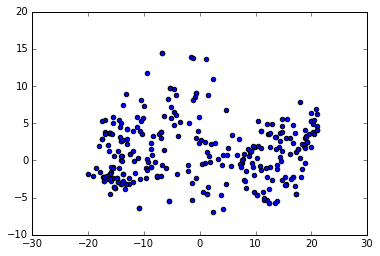

In [18]:
# display(df_candidates[['1','2','3','4','5','6','7','8','9','10',
#                                              '11','12','13','14','15','16','17','18','19','20']])

scores_reduced_candidates = pca_model.transform(df_candidates[['1','2','3','4','5','6','7','8','9','10',
                                             '11','12','13','14','15','16','17','18','19','20']])


df_candidates['x_pca'] = scores_reduced_candidates[:,0]
df_candidates['y_pca'] = scores_reduced_candidates[:,1]

#predict labels
kmeans_labels = kmeans_model.predict(zip(df_candidates['x_pca'], df_candidates['y_pca']))

#add cluster groupings
df_candidates['8_clusters'] = kmeans_labels

#show scatter plot candidates in PCA model; note is much more spread and less concentrated
plt.scatter(df_candidates['x_pca'],df_candidates['y_pca'])

display(df_candidates.head())

**LOAD STATE-LEVEL INFORMATION**

In [19]:
df_states = pd.DataFrame.from_csv("text_files/state_level_census.csv")

#rename "State" & "Year"
df_states = df_states.rename(columns={'State': 'state_full', 'Year': 'census_year'})


display(df_states.head(5))

,state_full,census_year,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance
0,Alabama,2015,23.019,16.439,12.435,13.163,13.899,21.045,24.738,29.909,13.661,31.692,0.337,52.571,41.708,5.384,1.439,3.462,96.538,51.536,48.464,0.494,1.234,26.426,98.310,1.264,0.050,1.690,68.841,87.343,12.657
1,Alaska,2015,25.652,19.292,13.598,12.674,14.266,14.518,27.901,28.208,6.569,37.322,2.952,62.120,29.393,5.535,14.903,7.370,92.630,47.618,52.382,13.815,5.853,3.412,91.579,1.264,1.206,8.421,66.030,81.820,18.180
2,Arizona,2015,24.350,16.724,12.766,12.589,12.513,21.059,27.637,23.489,13.790,35.084,0.330,54.030,40.345,5.295,1.142,13.490,86.510,50.329,49.671,4.437,3.013,4.239,96.810,6.487,0.188,3.190,78.446,84.964,15.036
3,Arkansas,2015,23.927,16.240,12.605,12.655,13.343,21.229,22.310,34.120,13.061,30.508,0.205,53.946,41.342,4.507,2.224,4.693,95.307,50.919,49.081,0.622,1.364,15.541,97.886,2.112,0.231,2.114,78.015,85.838,14.162
4,California,2015,23.878,17.842,13.815,13.608,13.069,17.787,32.043,20.342,17.429,30.186,0.435,56.895,36.431,6.239,0.233,27.042,72.958,50.322,49.678,0.747,13.695,5.896,95.485,12.948,0.391,4.515,61.807,85.298,14.702


In [20]:
### STATES MAPPING NECESSARY FOR CONVERSION
states_map = us_states.mapping('abbr', 'name')

#also create reverse mapping
states_reverse_map = us_states.mapping('name', 'abbr')

In [21]:
#MAP STATE ABBREV INTO DF_STATES AT END
df_states['state'] = df_states['state_full'].map(states_reverse_map)

display(df_states.head(5))

,state_full,census_year,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,state
0,Alabama,2015,23.019,16.439,12.435,13.163,13.899,21.045,24.738,29.909,13.661,31.692,0.337,52.571,41.708,5.384,1.439,3.462,96.538,51.536,48.464,0.494,1.234,26.426,98.310,1.264,0.050,1.690,68.841,87.343,12.657,AL
1,Alaska,2015,25.652,19.292,13.598,12.674,14.266,14.518,27.901,28.208,6.569,37.322,2.952,62.120,29.393,5.535,14.903,7.370,92.630,47.618,52.382,13.815,5.853,3.412,91.579,1.264,1.206,8.421,66.030,81.820,18.180,AK
2,Arizona,2015,24.350,16.724,12.766,12.589,12.513,21.059,27.637,23.489,13.790,35.084,0.330,54.030,40.345,5.295,1.142,13.490,86.510,50.329,49.671,4.437,3.013,4.239,96.810,6.487,0.188,3.190,78.446,84.964,15.036,AZ
3,Arkansas,2015,23.927,16.240,12.605,12.655,13.343,21.229,22.310,34.120,13.061,30.508,0.205,53.946,41.342,4.507,2.224,4.693,95.307,50.919,49.081,0.622,1.364,15.541,97.886,2.112,0.231,2.114,78.015,85.838,14.162,AR
4,California,2015,23.878,17.842,13.815,13.608,13.069,17.787,32.043,20.342,17.429,30.186,0.435,56.895,36.431,6.239,0.233,27.042,72.958,50.322,49.678,0.747,13.695,5.896,95.485,12.948,0.391,4.515,61.807,85.298,14.702,CA


**BRING IN ELIGIBLE VOTERS INFO TO STATES DATAFRAME**

In [22]:
df_eligible_voters = pd.DataFrame.from_csv("text_files/voting_eligible_figures.csv")
df_eligible_voters.reset_index(inplace=True)



# rename "State" & "State Abv" & "VEP"
df_eligible_voters = df_eligible_voters.rename(columns={'State': 'state_full', 'State Abv': 'state',
'Voting-Eligible Population (VEP)':'eligible_voters'})


#make float
df_eligible_voters['eligible_voters'] = df_eligible_voters['eligible_voters'].str.replace(',', '')
df_eligible_voters['eligible_voters'] = df_eligible_voters['eligible_voters'].map(float)

display(df_eligible_voters.head(5))

,state_full,state,State Results Website,Status,VEP Total Ballots Counted,VEP Highest Office,VAP Highest Office,Total Ballots Counted (Estimate),Highest Office,eligible_voters,Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,Overseas Eligible
0,Alabama,AL,http://www.alabamavotes.gov/downloads/election...,Official,59.30%,59.00%,56.30%,"2,134,061","2,123,372",3601361.0,"3,770,142",2.60%,"30,627","56,700","8,138","71,084",NaN
1,Alaska,AK,http://www.elections.alaska.gov/results/16GENR/,Official,61.80%,61.30%,57.40%,"321,271","318,608",519849.0,"555,367",4.30%,"5,338","7,077","2,210","11,582",NaN
2,Arizona,AZ,http://apps.azsos.gov/election/2016/General/Of...,Official,56.20%,55.00%,48.90%,"2,661,497","2,604,657",4734313.0,"5,331,034",9.50%,"38,068","76,005","7,379","88,770",NaN
3,Arkansas,AR,http://results.enr.clarityelections.com/AR/639...,Official,53.10%,52.80%,49.40%,"1,137,772","1,130,635",2142571.0,"2,286,625",3.80%,"17,405","28,900","23,093","56,971",NaN
4,California,CA,http://www.sos.ca.gov/elections/prior-election...,Official,58.40%,56.70%,47.00%,"14,610,509","14,181,595",25017408.0,"30,201,571",16.70%,"129,593",0,0,"129,593",NaN


In [23]:
### MERGE ELIGIBLE VOTER INFO INTO STATES INFO
df_states = pd.merge(df_states,
                     df_eligible_voters[['eligible_voters','state']],
                 on='state',
              how='left')

df_states.head()

,state_full,census_year,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,state,eligible_voters
0,Alabama,2015,23.019,16.439,12.435,13.163,13.899,21.045,24.738,29.909,13.661,31.692,0.337,52.571,41.708,5.384,1.439,3.462,96.538,51.536,48.464,0.494,1.234,26.426,98.310,1.264,0.050,1.690,68.841,87.343,12.657,AL,3601361.0
1,Alaska,2015,25.652,19.292,13.598,12.674,14.266,14.518,27.901,28.208,6.569,37.322,2.952,62.120,29.393,5.535,14.903,7.370,92.630,47.618,52.382,13.815,5.853,3.412,91.579,1.264,1.206,8.421,66.030,81.820,18.180,AK,519849.0
2,Arizona,2015,24.350,16.724,12.766,12.589,12.513,21.059,27.637,23.489,13.790,35.084,0.330,54.030,40.345,5.295,1.142,13.490,86.510,50.329,49.671,4.437,3.013,4.239,96.810,6.487,0.188,3.190,78.446,84.964,15.036,AZ,4734313.0
3,Arkansas,2015,23.927,16.240,12.605,12.655,13.343,21.229,22.310,34.120,13.061,30.508,0.205,53.946,41.342,4.507,2.224,4.693,95.307,50.919,49.081,0.622,1.364,15.541,97.886,2.112,0.231,2.114,78.015,85.838,14.162,AR,2142571.0
4,California,2015,23.878,17.842,13.815,13.608,13.069,17.787,32.043,20.342,17.429,30.186,0.435,56.895,36.431,6.239,0.233,27.042,72.958,50.322,49.678,0.747,13.695,5.896,95.485,12.948,0.391,4.515,61.807,85.298,14.702,CA,25017408.0


In [24]:
### MERGE STATE INFO
df = pd.merge(df_candidates,
                 df_states,
                 on='state',
              how='left')

display(df)

,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,x_pca,y_pca,8_clusters,state_full,census_year,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,eligible_voters
0,Al Franken,Al_Franken,2014,Al_Franken_2014,1052794,MN,http://www.ontheissues.org/Senate/Al_Franken.htm,1052794.0,1980016,1,53.2%,-5.0,-2.5,-5.0,-2.5,-5.0,-5.0,-2.5,-2.5,-2.5,-5.0,-5.0,-5.0,-2.5,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,Al Franken_2014,1.0,-42.5,-42.5,1.0,0.0,0.0,0.0,0.0,19.998385,6.345685,2,Minnesota,2015,23.633,16.090,12.942,13.111,14.448,19.776,36.008,23.113,6.190,34.689,0.047,66.038,29.996,3.919,1.800,7.726,92.274,50.321,49.679,1.044,4.443,5.521,97.339,1.515,0.036,2.661,84.780,92.966,7.034,3966155.0
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.6%,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,0.0,-37.5,40.0,0.0,0.0,1.0,0.0,0.0,-1.517772,13.910932,6,New York,2015,21.612,17.465,13.163,13.602,14.001,20.157,36.567,24.880,12.311,26.242,0.148,58.125,36.520,5.208,0.452,22.481,77.519,51.498,48.502,0.380,7.982,15.607,97.149,8.569,0.033,2.851,64.578,90.338,9.662,13591250.0
2,Alexander Pires,Alex_Pires,2012,Alex_Pires_2012,265374,DE,http://www.ontheissues.org/Senate/Alex_Pires.htm,15300.0,399559,0,3.8%,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,0.0,0.0,0.0,-2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alexander Pires_2012,0.0,-10.0,-15.0,0.0,0.0,0.0,1.0,0.0,7.742928,0.233888,1,Delaware,2015,22.036,16.543,12.226,12.920,14.131,22.144,31.565,29.724,10.303,28.408,0.398,58.234,36.505,4.862,9.798,8.653,91.347,51.599,48.401,0.339,3.631,21.640,97.273,2.266,0.033,2.727,69.364,91.763,8.237,689125.0
3,Alexander Giannoulias,Alexi_Giannoulias,2010,Alexi_Giannoulias_2010,1778698,IL,http://www.ontheissues.org/Senate/Alexi_Gianno...,1719478.0,3703901,0,46.4%,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-2.5,0.0,0.0,-5.0,-2.5,-5.0,-2.5,-5.0,2.5,0.0,-2.5,-5.0,0.0,5.0,Alexander Giannoulias_2010,0.0,-20.0,-32.5,1.0,0.0,0.0,0.0,0.0,14.216940,1.754576,7,Illinois,2015,23.488,16.625,13.410,13.420,13.844,19.213,34.731,24.700,10.442,30.127,0.171,59.658,34.206,5.965,0.701,14.011,85.989,50.932,49.068,0.220,5.015,14.340,97.751,5.810,0.026,2.249,72.339,88.982,11.018,8943045.0
4,Alison Lundergan Grimes,Alison_Grimes,2014,Alison_Grimes_2014,806795,KY,http://www.ontheissues.org/Senate/Alison_Grime...,584699.0,1435734,0,40.7%,-5.0,-5.0,-5.0,0.0,-5.0,-2.5,-2.5,2.5,2.5,2.5,-2.5,-2.5,-2.5,0.0,2.5,-2.5,-2.5,2.5,-2.5,-5.0,Alison Lundergan Grimes_2014,0.0,-12.5,-20.0,1.0,0.0,0.0,0.0,0.0,8.929680,1.301677,1,Kentucky,2015,23.106,16.072,12.713,13.427,14.173,20.509,23.854,32.982,12.651,30.513,0.422,54.146,40.441,4.990,1.585,3.435,96.565,50.784,49.216,0.206,1.262,7.892,97.934,0.936,0.050,2.066,87.589,88.631,11.369,3276651.0
5,Allen Buckley,Allen_Buckley,2016,Allen_Buckley_2016,2110737,GA,http://www.ontheissues.org/Senate/Allen_Buckle...,159914.0,3835657,0,4.2%,-2.5,5.0,-2.5,0.0,5.0,0.0,-2.5,0.0,5.0,5.0,2.5,5.0,-2.5,2.5,-5.0,0.0,2.5,-5.0,-5.0,5.0,Allen Buckley_2016,0.0,-2.5,15.0,0.0,0.0,1.0,0.0,0.0,-1.848414,5.018793,6,Georgia,2015,24.894,17.003,13.508,14.132,13.173,17.291,30.227,27.323,12.939,29.511,0.630,56.317,37.035,6.018,0.7

In [25]:
#MODIFY VOTE RESULTS FROM STRING TO PERCENTAGE FLOAT

def p2f(x):
    return float(x.strip('%'))/100

df['%_votes_state'] = df['%_votes_state'].map(p2f)
display(df['%_votes_state'].head())

0    0.532
1    0.006
2    0.038
3    0.464
4    0.407
Name: %_votes_state, dtype: float64

**REPLACE NaN WITH ZEROS**  
_WILL WANT TO IMPROVE THIS ASSUMPTION IN NON-BASELINE MODEL_

In [26]:
df = df.fillna(0)

**COMBINE INTO MAIN DATAFRAME FOR MODEL (TRAIN, TEST, VALIDATION)**  
_Due to lack of data use cross-validation for output_

In [27]:
np.random.seed(100)

### LIST STATES AND PICK FOR TEST / VALIDATION FROM 2016
states = df[df['year']==2016]['state'].unique()
# print len(states)
#CHOOSE 27 OF TOTAL 34 STATES FOR TEST SET (7 FOR VALIDATION)
test_states = np.random.choice(states, 27, replace=False)
validation_states = np.array(list(set(states) - set(test_states)))

print "2016 STATES:", states
print "TEST STATES:", test_states
print "VALIDATION STATES:", validation_states


### ASSIGN NORMALIZED SCORE ###
def assign_dataset(row) :
    #assign train, test, validation set
    if (row['year'] == 2012) or (row['year'] == 2014):
        return "TRAIN"
    elif (row['year'] == 2016) :
        if row['state'] in test_states :
            return "TEST"
        else :
            return "VALIDATION"        
    else :
        return "OTHER"
    
df['dataset'] = df.apply(assign_dataset, axis=1)

print "\nDF HEAD"
display(df.head())

### DEFINE VARIABLES, OUTPUT

##UNCOMMENT RELEVANT COLUMNS DEPENDING ON WHAT WISH TO USE FOR DATA INPUT
# data_columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']


data_columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20',
                "age_0_17", "age_18_29", "age_30_39", "age_40_49",
                "age_50_59", "age_60_plus", "education_bachelors_or_higher_age_25_64", "education_high_school_diploma_age_25_64",
                "education_less_than_high_school_diploma_age_25_64", "education_some_college_age_25_64", 
                "employment_armed_forces", "employment_employed", "employment_not_in_labor_force", "employment_unemployed", 
                "median_family_income", "place_of_birth_foreign", "place_of_birth_native", "population_female", 
                "population_male", "race_american_indian_and_alaska_native", "race_asian", "race_black", "race_one_race", 
                "race_other", "race_pacific_islander", "race_two_or_more_races", "race_white", "with_health_insurance",
                "without_health_insurance",
                "party_abbrev_D","party_abbrev_I","party_abbrev_L","party_abbrev_OTH","party_abbrev_R",
                "incumbent"

               ]



#set up train/test/validation
df_train = df[df['dataset']=="TRAIN"]
df_test = df[df['dataset']=="TEST"]
df_validation = df[df['dataset']=="VALIDATION"]

#UNCOMMENT ONLY WHEN LOOKING TO PREDICT FULL DATA SET: TEST & VALIDATION
df_test = df[(df['dataset']=="TEST")|(df['dataset']=="VALIDATION")]

print "TRAIN DATA"
X_train = df_train[data_columns]
display(X_train.head())

y_train = df_train['%_votes_state']
display(y_train.head())

print "TEST DATA"
X_test = df_test[data_columns]
display(X_test.head())

y_test = df_test['%_votes_state']
display(y_test.head())


print "VALIDATION DATA"
X_validation = df_validation[data_columns]
display(X_validation.head())

y_validation = df_validation['%_votes_state']
display(y_validation.head())

2016 STATES: ['NY' 'GA' 'AZ' 'HI' 'NV' 'LA' 'MD' 'WA' 'IA' 'AR' 'CT' 'CO' 'NC' 'ND' 'IN'
 'OK' 'MO' 'SD' 'KS' 'ID' 'KY' 'AK' 'CA' 'PA' 'NH' 'FL' 'OR' 'IL' 'UT' 'VT'
 'WI' 'AL' 'OH' 'SC']
TEST STATES: ['FL' 'SC' 'WI' 'LA' 'GA' 'ND' 'KS' 'AL' 'ID' 'MD' 'AR' 'NY' 'OR' 'NC' 'CO'
 'NV' 'UT' 'IL' 'SD' 'VT' 'IN' 'CA' 'OH' 'AK' 'AZ' 'KY' 'CT']
VALIDATION STATES: ['NH' 'OK' 'PA' 'WA' 'MO' 'HI' 'IA']

DF HEAD


,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,x_pca,y_pca,8_clusters,state_full,census_year,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,eligible_voters,dataset
0,Al Franken,Al_Franken,2014,Al_Franken_2014,1052794,MN,http://www.ontheissues.org/Senate/Al_Franken.htm,1052794.0,1980016,1,0.532,-5.0,-2.5,-5.0,-2.5,-5.0,-5.0,-2.5,-2.5,-2.5,-5.0,-5.0,-5.0,-2.5,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,Al Franken_2014,1.0,-42.5,-42.5,1.0,0.0,0.0,0.0,0.0,19.998385,6.345685,2,Minnesota,2015,23.633,16.090,12.942,13.111,14.448,19.776,36.008,23.113,6.190,34.689,0.047,66.038,29.996,3.919,1.800,7.726,92.274,50.321,49.679,1.044,4.443,5.521,97.339,1.515,0.036,2.661,84.780,92.966,7.034,3966155.0,TRAIN
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.006,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,0.0,-37.5,40.0,0.0,0.0,1.0,0.0,0.0,-1.517772,13.910932,6,New York,2015,21.612,17.465,13.163,13.602,14.001,20.157,36.567,24.880,12.311,26.242,0.148,58.125,36.520,5.208,0.452,22.481,77.519,51.498,48.502,0.380,7.982,15.607,97.149,8.569,0.033,2.851,64.578,90.338,9.662,13591250.0,TEST
2,Alexander Pires,Alex_Pires,2012,Alex_Pires_2012,265374,DE,http://www.ontheissues.org/Senate/Alex_Pires.htm,15300.0,399559,0,0.038,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,0.0,0.0,0.0,-2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alexander Pires_2012,0.0,-10.0,-15.0,0.0,0.0,0.0,1.0,0.0,7.742928,0.233888,1,Delaware,2015,22.036,16.543,12.226,12.920,14.131,22.144,31.565,29.724,10.303,28.408,0.398,58.234,36.505,4.862,9.798,8.653,91.347,51.599,48.401,0.339,3.631,21.640,97.273,2.266,0.033,2.727,69.364,91.763,8.237,689125.0,TRAIN
3,Alexander Giannoulias,Alexi_Giannoulias,2010,Alexi_Giannoulias_2010,1778698,IL,http://www.ontheissues.org/Senate/Alexi_Gianno...,1719478.0,3703901,0,0.464,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-2.5,0.0,0.0,-5.0,-2.5,-5.0,-2.5,-5.0,2.5,0.0,-2.5,-5.0,0.0,5.0,Alexander Giannoulias_2010,0.0,-20.0,-32.5,1.0,0.0,0.0,0.0,0.0,14.216940,1.754576,7,Illinois,2015,23.488,16.625,13.410,13.420,13.844,19.213,34.731,24.700,10.442,30.127,0.171,59.658,34.206,5.965,0.701,14.011,85.989,50.932,49.068,0.220,5.015,14.340,97.751,5.810,0.026,2.249,72.339,88.982,11.018,8943045.0,OTHER
4,Alison Lundergan Grimes,Alison_Grimes,2014,Alison_Grimes_2014,806795,KY,http://www.ontheissues.org/Senate/Alison_Grime...,584699.0,1435734,0,0.407,-5.0,-5.0,-5.0,0.0,-5.0,-2.5,-2.5,2.5,2.5,2.5,-2.5,-2.5,-2.5,0.0,2.5,-2.5,-2.5,2.5,-2.5,-5.0,Alison Lundergan Grimes_2014,0.0,-12.5,-20.0,1.0,0.0,0.0,0.0,0.0,8.929680,1.301677,1,Kentucky,2015,23.106,16.072,12.713,13.427,14.173,20.509,23.854,32.982,12.651,30.513,0.422,54.146,40.441,4.990,1.585,3.435,96.565,50.784,49.216,0.206,1.262,7.892,97.934,0.936,0.050,2.066,87.589,88.631,11.369,3276651.0,TRAIN


TRAIN DATA


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,incumbent
0,-5.0,-2.5,-5.0,-2.5,-5.0,-5.0,-2.5,-2.5,-2.5,-5.0,-5.0,-5.0,-2.5,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,23.633,16.090,12.942,13.111,14.448,19.776,36.008,23.113,6.190,34.689,0.047,66.038,29.996,3.919,1.800,7.726,92.274,50.321,49.679,1.044,4.443,5.521,97.339,1.515,0.036,2.661,84.780,92.966,7.034,1.0,0.0,0.0,0.0,0.0,1.0
2,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,0.0,0.0,0.0,-2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.036,16.543,12.226,12.920,14.131,22.144,31.565,29.724,10.303,28.408,0.398,58.234,36.505,4.862,9.798,8.653,91.347,51.599,48.401,0.339,3.631,21.640,97.273,2.266,0.033,2.727,69.364,91.763,8.237,0.0,0.0,0.0,1.0,0.0,0.0
4,-5.0,-5.0,-5.0,0.0,-5.0,-2.5,-2.5,2.5,2.5,2.5,-2.5,-2.5,-2.5,0.0,2.5,-2.5,-2.5,2.5,-2.5,-5.0,23.106,16.072,12.713,13.427,14.173,20.509,23.854,32.982,12.651,30.513,0.422,54.146,40.441,4.990,1.585,3.435,96.565,50.784,49.216,0.206,1.262,7.892,97.934,0.936,0.050,2.066,87.589,88.631,11.369,1.0,0.0,0.0,0.0,0.0,0.0
6,5.0,0.0,2.5,0.0,5.0,-2.5,5.0,5.0,2.5,5.0,2.5,5.0,0.0,2.5,5.0,5.0,5.0,5.0,0.0,5.0,24.312,16.817,12.413,11.991,13.621,20.847,25.887,26.462,14.473,33.178,0.547,53.636,40.373,5.444,3.370,9.774,90.226,50.463,49.537,9.142,1.380,2.099,96.735,10.885,0.061,3.265,73.168,83.590,16.410,0.0,0.0,0.0,0.0,1.0,0.0
8,-5.0,-5.0,-5.0,0.0,-2.5,-5.0,-5.0,-2.5,-5.0,-2.5,-2.5,-5.0,0.0,0.0,0.0,-5.0,0.0,-2.5,-5.0,-2.5,22.114,16.061,12.112,11.558,15.035,23.121,30.405,28.694,5.962,34.940,0.432,59.589,36.007,3.972,7.521,2.068,97.932,49.723,50.277,6.474,0.708,0.469,97.460,0.538,0.084,2.540,89.187,84.461,15.539,1.0,0.0,0.0,0.0,0.0,0.0


0    0.532
2    0.038
4    0.407
6    0.446
8    0.400
Name: %_votes_state, dtype: float64

TEST DATA


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,incumbent
1,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,21.612,17.465,13.163,13.602,14.001,20.157,36.567,24.880,12.311,26.242,0.148,58.125,36.520,5.208,0.452,22.481,77.519,51.498,48.502,0.380,7.982,15.607,97.149,8.569,0.033,2.851,64.578,90.338,9.662,0.0,0.0,1.0,0.0,0.0,0.0
5,-2.5,5.0,-2.5,0.0,5.0,0.0,-2.5,0.0,5.0,5.0,2.5,5.0,-2.5,2.5,-5.0,0.0,2.5,-5.0,-5.0,5.0,24.894,17.003,13.508,14.132,13.173,17.291,30.227,27.323,12.939,29.511,0.630,56.317,37.035,6.018,0.762,9.808,90.192,51.199,48.801,0.259,3.602,30.947,97.863,2.792,0.047,2.137,60.217,82.879,17.121,0.0,0.0,1.0,0.0,0.0,0.0
12,-5.0,-5.0,-5.0,2.5,-2.5,-5.0,-2.5,-2.5,2.5,5.0,-5.0,5.0,2.5,-5.0,5.0,-5.0,-2.5,2.5,-5.0,-5.0,24.350,16.724,12.766,12.589,12.513,21.059,27.637,23.489,13.790,35.084,0.330,54.030,40.345,5.295,1.142,13.490,86.510,50.329,49.671,4.437,3.013,4.239,96.810,6.487,0.188,3.190,78.446,84.964,15.036,1.0,0.0,0.0,0.0,0.0,0.0
30,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,-5.0,2.5,-5.0,5.0,-2.5,2.5,5.0,-2.5,-5.0,-2.5,-5.0,2.5,-2.5,21.915,17.264,13.168,12.629,13.278,21.745,32.016,26.708,6.521,34.755,3.659,57.788,34.812,3.741,7.145,17.729,82.271,49.522,50.478,0.214,37.727,2.040,76.312,1.057,9.877,23.688,25.397,94.068,5.932,1.0,0.0,0.0,0.0,0.0,1.0
35,-5.0,-5.0,2.5,0.0,-5.0,-5.0,-5.0,-5.0,2.5,-2.5,-2.5,-5.0,-5.0,-2.5,0.0,-5.0,2.5,-5.0,-2.5,-2.5,23.639,16.228,13.825,13.778,13.143,19.387,22.888,27.952,14.736,34.425,0.399,57.330,35.555,6.716,2.756,19.197,80.803,49.699,50.301,1.122,7.677,8.423,95.607,8.795,0.641,4.393,68.950,81.707,18.293,1.0,0.0,0.0,0.0,0.0,0.0


1     0.006
5     0.042
12    0.411
30    0.739
35    0.471
Name: %_votes_state, dtype: float64

VALIDATION DATA


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,incumbent
30,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,-5.0,2.5,-5.0,5.0,-2.5,2.5,5.0,-2.5,-5.0,-2.5,-5.0,2.5,-2.5,21.915,17.264,13.168,12.629,13.278,21.745,32.016,26.708,6.521,34.755,3.659,57.788,34.812,3.741,7.145,17.729,82.271,49.522,50.478,0.214,37.727,2.040,76.312,1.057,9.877,23.688,25.397,94.068,5.932,1.0,0.0,0.0,0.0,0.0,1.0
46,0.0,0.0,-2.5,0.0,2.5,-2.5,5.0,-2.5,0.0,0.0,0.0,-5.0,5.0,5.0,5.0,0.0,2.5,2.5,0.0,2.5,22.856,16.789,13.595,13.249,13.840,19.671,33.605,22.226,9.033,35.136,0.872,58.540,35.599,4.989,1.329,13.422,86.578,50.072,49.928,1.335,7.666,3.625,94.836,3.785,0.632,5.164,77.793,88.552,11.448,0.0,0.0,0.0,0.0,1.0,0.0
48,5.0,5.0,5.0,5.0,2.5,2.5,5.0,-2.5,2.5,5.0,5.0,5.0,5.0,5.0,2.5,2.5,5.0,2.5,5.0,2.5,23.489,16.463,12.244,12.242,13.883,21.679,29.095,28.447,7.059,35.399,0.070,64.293,32.297,3.340,2.757,4.731,95.269,50.393,49.607,0.323,2.036,3.161,98.029,1.289,0.061,1.971,91.160,92.696,7.304,0.0,0.0,0.0,0.0,1.0,1.0
99,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,-5.0,5.0,5.0,5.0,2.5,5.0,5.0,-2.5,5.0,5.0,0.0,2.5,24.623,17.030,12.872,12.245,13.350,19.881,25.085,30.658,11.890,32.366,0.617,57.257,38.263,3.862,1.932,5.764,94.236,50.466,49.534,7.254,1.937,7.236,92.209,2.569,0.122,7.791,73.091,83.344,16.656,0.0,0.0,0.0,0.0,1.0,1.0
100,-5.0,-2.5,-5.0,0.0,-5.0,-2.5,5.0,-5.0,-2.5,-5.0,2.5,-2.5,-2.5,-2.5,2.5,-2.5,-2.5,-5.0,2.5,-2.5,23.169,16.427,12.538,12.665,14.221,20.980,29.196,29.140,9.765,31.898,0.404,58.455,36.425,4.716,1.266,3.928,96.072,50.971,49.029,0.413,1.762,11.530,97.558,1.118,0.102,2.442,82.633,87.753,12.247,1.0,0.0,0.0,0.0,0.0,0.0


30     0.739
46     0.409
48     0.602
99     0.677
100    0.462
Name: %_votes_state, dtype: float64

**GET STATS PER MODEL AND PICK MODEL**

In [28]:
# !pip install xgboost --upgrade

In [29]:
### LEVERAGED http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py
### FOR THIS SIMPLE MODEL
### SHOULD ALSO TRY CLASSIFIERS RATHER THAN REGRESSORS?

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor 
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
#if don't have xgboost installed can comment out (as well as in models and model_names)
# from xgboost import XGBRegressor



from math import sqrt


import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

def max_pred_test(state):
    return df_test_maxes[state]

def winner_pred(row):
    if row['pred'] == row['max_pred'] :
        return 1
    else :
        return 0
    
def is_correct(row):
    if row['winner'] == row['winner_pred'] :
        return 1
    else :
        return 0

      
#sometimes commenting out XGBoost due to complications of install on certain OS's
### BUT, should bring back as it is the most accurate
models = [LinearRegression(), Ridge(), RidgeCV(), ElasticNet(), LassoCV(), LassoLarsCV(),
          GradientBoostingRegressor(), AdaBoostRegressor(), ExtraTreesRegressor(),
         SVR(), DecisionTreeRegressor(), BaggingRegressor(), RandomForestRegressor()
         #,XGBRegressor()
         ]
model_names = ['LinReg', 'Ridge', 'RidgeCV', 'ElasticNet', 'LassoCV', 'LassoLarsCV',
               'GradientBoostingRegressor', 'AdaBoost', 'ExtraTreesRegressor',
              'SVR','DecisionTreeRegressor','BaggingRegressor', 'RandomForestRegressor'
              #,'XGBRegressor'
              ]
rmse = []

np.random.seed(100)

for model, model_name in zip(models, model_names) :
    # Create linear regression object

    print "MODEL:", model_name
    
    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Make predictions using the testing set and validation set
    y_test_pred = model.predict(X_test)
    y_validation_pred = model.predict(X_validation)

    # The coefficients
    # print('Coefficients: \n', model.coef_)
    # The mean squared error
    print("Mean squared error: %.4f"
          % mean_squared_error(y_test, y_test_pred))
    print("Mean absolute error: %.4f"
          % mean_absolute_error(y_test, y_test_pred))
    print("Root mean square error: %.4f"
          % sqrt(mean_squared_error(y_test, y_test_pred)))

    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_test_pred))


    #### **APPLY BACK TO DF TO GET NUMBER CORRECT (ONLY ACTUALLY CHECK TEST - LEAVE VALIDATON)** ###

    #add additional error columns in test
    df_test['pred'] = y_test_pred
    df_test['error'] = df_test['pred'] - df_test['%_votes_state']
    df_test['sq_error'] = (df_test['pred'] - df_test['%_votes_state'])**2

    df_test_groupby = df_test.groupby(['state'])['pred'].max()
    df_test_maxes = dict(df_test_groupby)

    #apply max to test
    df_test['max_pred'] = df_test['state'].apply(max_pred_test)

    #determine whether winner
    df_test['winner_pred'] = df_test.apply(winner_pred, axis=1)

    #determine whether winner
    df_test['is_correct'] = df_test.apply(is_correct, axis=1)

    # print "FINAL DF TEST HEADER"
    # display(df_test.head())

    #append to RMSEs for comparison
    rmse.append(sqrt(mean_squared_error(y_test, y_test_pred)))
    
    print "WINNER CORRECT/INCORRECT STATS"
    display(df_test.groupby(['winner', 'is_correct']).size().reset_index(name='counts'))
    
    print "\n\n\n\n"

    #when ready, copy/paste the code above for VALIDATION (replacing all "test" with "validation")

print "ALL MODELS: ACCURACY (RMSE) ORDER"
print sorted(zip(model_names, rmse), key = lambda x: float(x[1]))
# print list(zip(model_names, rmse)).sort(key=lambda x: x[1])

MODEL: LinReg
Mean squared error: 0.0176
Mean absolute error: 0.1009
Root mean square error: 0.1326
Variance score: 0.57


C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,5
1,0,1,42
2,1,0,5
3,1,1,29







MODEL: Ridge
Mean squared error: 0.0180
Mean absolute error: 0.1005
Root mean square error: 0.1342
Variance score: 0.56
WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,5
1,0,1,42
2,1,0,5
3,1,1,29







MODEL: RidgeCV
Mean squared error: 0.0180
Mean absolute error: 0.1005
Root mean square error: 0.1342
Variance score: 0.56
WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,5
1,0,1,42
2,1,0,5
3,1,1,29







MODEL: ElasticNet
Mean squared error: 0.0409
Mean absolute error: 0.1629
Root mean square error: 0.2023
Variance score: -0.00
WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,47
1,1,1,34







MODEL: LassoCV


C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Mean squared error: 0.0182
Mean absolute error: 0.1019
Root mean square error: 0.1350
Variance score: 0.55
WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,5
1,0,1,42
2,1,0,5
3,1,1,29







MODEL: LassoLarsCV
Mean squared error: 0.0167
Mean absolute error: 0.0966
Root mean square error: 0.1292
Variance score: 0.59


C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 37 iterations, i.e. alpha=2.466e-04, with an active set of 33 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning)
C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=1.814e-04, with an active set of 34 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning)
C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=1.860e-04, previous alpha=1.716e-04, with an

WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,4
1,0,1,43
2,1,0,4
3,1,1,30







MODEL: GradientBoostingRegressor
Mean squared error: 0.0127
Mean absolute error: 0.0807
Root mean square error: 0.1126
Variance score: 0.69
WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,5
1,0,1,42
2,1,0,5
3,1,1,29







MODEL: AdaBoost
Mean squared error: 0.0128
Mean absolute error: 0.0849
Root mean square error: 0.1131
Variance score: 0.69
WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,5
1,0,1,42
2,1,0,5
3,1,1,29







MODEL: ExtraTreesRegressor
Mean squared error: 0.0111
Mean absolute error: 0.0742
Root mean square error: 0.1055
Variance score: 0.73
WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,6
1,0,1,41
2,1,0,6
3,1,1,28







MODEL: SVR
Mean squared error: 0.0334
Mean absolute error: 0.1507
Root mean square error: 0.1826
Variance score: 0.18
WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,9
1,0,1,38
2,1,0,9
3,1,1,25







MODEL: DecisionTreeRegressor
Mean squared error: 0.0155
Mean absolute error: 0.0926
Root mean square error: 0.1247
Variance score: 0.62
WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,7
1,0,1,40
2,1,0,7
3,1,1,27







MODEL: BaggingRegressor
Mean squared error: 0.0109
Mean absolute error: 0.0774
Root mean square error: 0.1045
Variance score: 0.73
WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,5
1,0,1,42
2,1,0,5
3,1,1,29







MODEL: RandomForestRegressor
Mean squared error: 0.0108
Mean absolute error: 0.0799
Root mean square error: 0.1040
Variance score: 0.73
WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,6
1,0,1,41
2,1,0,6
3,1,1,28







ALL MODELS: ACCURACY (RMSE) ORDER
[('RandomForestRegressor', 0.10404670307007852), ('BaggingRegressor', 0.10450006734004566), ('ExtraTreesRegressor', 0.10548943192051792), ('GradientBoostingRegressor', 0.11261131228440938), ('AdaBoost', 0.113086428807583), ('DecisionTreeRegressor', 0.12469850058995384), ('LassoLarsCV', 0.12923562238187264), ('LinReg', 0.1326252231952675), ('RidgeCV', 0.1341583735145033), ('Ridge', 0.13415837351468354), ('LassoCV', 0.13500344186109825), ('SVR', 0.18262154074897918), ('ElasticNet', 0.20233034425741925)]


In [30]:
!pip install xgboost

In [31]:
# Check to see have proper number of incumbents (29 - 22 in test, 7 in validation)
display(df_test)
display(df_test[df_test['incumbent']==1].shape)
display(df_validation[df_validation['incumbent']==1].shape)

,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,x_pca,y_pca,8_clusters,state_full,census_year,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,eligible_voters,dataset,pred,error,sq_error,max_pred,winner_pred,is_correct
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.006,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,0.0,-37.5,40.0,0.0,0.0,1.0,0.0,0.0,-1.517772,13.910932,6,New York,2015,21.612,17.465,13.163,13.602,14.001,20.157,36.567,24.880,12.311,26.242,0.148,58.125,36.520,5.208,0.452,22.481,77.519,51.498,48.502,0.380,7.982,15.607,97.149,8.569,0.033,2.851,64.578,90.338,9.662,13591250.0,TEST,0.0271,0.0211,0.000445,0.6545,0,1
5,Allen Buckley,Allen_Buckley,2016,Allen_Buckley_2016,2110737,GA,http://www.ontheissues.org/Senate/Allen_Buckle...,159914.0,3835657,0,0.042,-2.5,5.0,-2.5,0.0,5.0,0.0,-2.5,0.0,5.0,5.0,2.5,5.0,-2.5,2.5,-5.0,0.0,2.5,-5.0,-5.0,5.0,Allen Buckley_2016,0.0,-2.5,15.0,0.0,0.0,1.0,0.0,0.0,-1.848414,5.018793,6,Georgia,2015,24.894,17.003,13.508,14.132,13.173,17.291,30.227,27.323,12.939,29.511,0.630,56.317,37.035,6.018,0.762,9.808,90.192,51.199,48.801,0.259,3.602,30.947,97.863,2.792,0.047,2.137,60.217,82.879,17.121,6955436.0,TEST,0.0527,0.0107,0.000114,0.5387,0,1
12,Ann Kirkpatrick,Ann_Kirkpatrick,2016,Ann_Kirkpatrick_2016,1089324,AZ,http://www.ontheissues.org/Senate/Ann_Kirkpatr...,839542.0,2041017,0,0.411,-5.0,-5.0,-5.0,2.5,-2.5,-5.0,-2.5,-2.5,2.5,5.0,-5.0,5.0,2.5,-5.0,5.0,-5.0,-2.5,2.5,-5.0,-5.0,Ann Kirkpatrick_2016,0.0,-10.0,-20.0,1.0,0.0,0.0,0.0,0.0,8.576817,1.558587,1,Arizona,2015,24.350,16.724,12.766,12.589,12.513,21.059,27.637,23.489,13.790,35.084,0.330,54.030,40.345,5.295,1.142,13.490,86.510,50.329,49.671,4.437,3.013,4.239,96.810,6.487,0.188,3.190,78.446,84.964,15.036,4734313.0,TEST,0.4944,0.0834,0.006956,0.5947,0,1
30,Brian Schatz,Brian_Schatz,2016,Brian_Schatz_2016,306543,HI,http://www.ontheissues.org/Senate/Brian_Schatz...,306543.0,415065,1,0.739,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,-5.0,2.5,-5.0,5.0,-2.5,2.5,5.0,-2.5,-5.0,-2.5,-5.0,2.5,-2.5,Brian Schatz_2016,1.0,-22.5,-12.5,1.0,0.0,0.0,0.0,0.0,10.237780,-4.623653,1,Hawaii,2015,21.915,17.264,13.168,12.629,13.278,21.745,32.016,26.708,6.521,34.755,3.659,57.788,34.812,3.741,7.145,17.729,82.271,49.522,50.478,0.214,37.727,2.040,76.312,1.057,9.877,23.688,25.397,94.068,5.932,1016971.0,VALIDATION,0.5311,-0.2079,0.043222,0.5311,1,1
35,Catherine Cortez Masto,Catherine_Cortez_Masto,2016,Catherine_Cortez_Masto_2016,520658,NV,http://www.ontheissues.org/Senate/Catherine_Co...,520658.0,1106020,1,0.471,-5.0,-5.0,2.5,0.0,-5.0,-5.0,-5.0,-5.0,2.5,-2.5,-2.5,-5.0,-5.0,-2.5,0.0,-5.0,2.5,-5.0,-2.5,-2.5,Catherine Cortez Masto_2016,0.0,-15.0,-40.0,1.0,0.0,0.0,0.0,0.0,13.847191,-1.132625,7,Nevada,2015,23.639,16.228,13.825,13.778,13.143,19.387,22.888,27.952,14.736,34.425,0.399,57.330,35.555,6.716,2.756,19.197,80.803,49.699,50.301,1.122,7.677,8.423,95.607,8.795,0.641,4.393,68.950,81.707,18.293,1964097.0,TEST,0.5093,0.0383,0.001467,0.5093,1,1
36,Charles Boustany,Charles_Boustany,2016,Charles_Boustany_2016,482380,LA,http://www.ontheissues.org/Senate/Charles_Bous...,297744.0,1932481

(29, 82)

(7, 76)

**APPLY BACK TO DF TO GET NUMBER CORRECT (ONLY ACTUALLY CHECK TEST - LEAVE VALIDATON)**

In [32]:
# CHOOSE MODEL
model = ExtraTreesRegressor()
model_name = "ExtraTreesRegressor"
    
print "MODEL:", model_name

# Train the model using the training sets
model.fit(X_train, y_train)

# Make predictions using the testing set and validation set
y_test_pred = model.predict(X_test)
y_validation_pred = model.predict(X_validation)

# The coefficients
# print('Coefficients: \n', model.coef_)
# The mean squared error
print("Mean squared error: %.4f"
      % mean_squared_error(y_test, y_test_pred))
print("Mean absolute error: %.4f"
      % mean_absolute_error(y_test, y_test_pred))
print("Root mean square error: %.4f"
      % sqrt(mean_squared_error(y_test, y_test_pred)))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_test_pred))


#add additional error columns in test
df_test['pred'] = y_test_pred
df_test['error'] = df_test['pred'] - df_test['%_votes_state']
df_test['sq_error'] = (df_test['pred'] - df_test['%_votes_state'])**2

df_test_groupby = df_test.groupby(['state'])['pred'].max()
df_test_maxes = dict(df_test_groupby)

def max_pred_test(state):
    return df_test_maxes[state]

def winner_pred(row):
    if row['pred'] == row['max_pred'] :
        return 1
    else :
        return 0
    
def is_correct(row):
    if row['winner'] == row['winner_pred'] :
        return 1
    else :
        return 0

#apply max to test
df_test['max_pred'] = df_test['state'].apply(max_pred_test)

#determine whether winner
df_test['winner_pred'] = df_test.apply(winner_pred, axis=1)

#determine whether winner
df_test['is_correct'] = df_test.apply(is_correct, axis=1)

display(df_test.head())

print "WINNER CORRECT/INCORRECT STATS"
display(df_test.groupby(['winner', 'is_correct']).size().reset_index(name='counts'))

#when ready, copy/paste the code above for VALIDATION (replacing all "test" with "validation")

MODEL: ExtraTreesRegressor
Mean squared error: 0.0129
Mean absolute error: 0.0796
Root mean square error: 0.1134
Variance score: 0.68


C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,x_pca,y_pca,8_clusters,state_full,census_year,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,eligible_voters,dataset,pred,error,sq_error,max_pred,winner_pred,is_correct
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.006,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,0.0,-37.5,40.0,0.0,0.0,1.0,0.0,0.0,-1.517772,13.910932,6,New York,2015,21.612,17.465,13.163,13.602,14.001,20.157,36.567,24.880,12.311,26.242,0.148,58.125,36.520,5.208,0.452,22.481,77.519,51.498,48.502,0.380,7.982,15.607,97.149,8.569,0.033,2.851,64.578,90.338,9.662,13591250.0,TEST,0.0319,0.0259,0.000671,0.7178,0,1
5,Allen Buckley,Allen_Buckley,2016,Allen_Buckley_2016,2110737,GA,http://www.ontheissues.org/Senate/Allen_Buckle...,159914.0,3835657,0,0.042,-2.5,5.0,-2.5,0.0,5.0,0.0,-2.5,0.0,5.0,5.0,2.5,5.0,-2.5,2.5,-5.0,0.0,2.5,-5.0,-5.0,5.0,Allen Buckley_2016,0.0,-2.5,15.0,0.0,0.0,1.0,0.0,0.0,-1.848414,5.018793,6,Georgia,2015,24.894,17.003,13.508,14.132,13.173,17.291,30.227,27.323,12.939,29.511,0.630,56.317,37.035,6.018,0.762,9.808,90.192,51.199,48.801,0.259,3.602,30.947,97.863,2.792,0.047,2.137,60.217,82.879,17.121,6955436.0,TEST,0.0332,-0.0088,0.000077,0.5902,0,1
12,Ann Kirkpatrick,Ann_Kirkpatrick,2016,Ann_Kirkpatrick_2016,1089324,AZ,http://www.ontheissues.org/Senate/Ann_Kirkpatr...,839542.0,2041017,0,0.411,-5.0,-5.0,-5.0,2.5,-2.5,-5.0,-2.5,-2.5,2.5,5.0,-5.0,5.0,2.5,-5.0,5.0,-5.0,-2.5,2.5,-5.0,-5.0,Ann Kirkpatrick_2016,0.0,-10.0,-20.0,1.0,0.0,0.0,0.0,0.0,8.576817,1.558587,1,Arizona,2015,24.350,16.724,12.766,12.589,12.513,21.059,27.637,23.489,13.790,35.084,0.330,54.030,40.345,5.295,1.142,13.490,86.510,50.329,49.671,4.437,3.013,4.239,96.810,6.487,0.188,3.190,78.446,84.964,15.036,4734313.0,TEST,0.4745,0.0635,0.004032,0.6251,0,1
30,Brian Schatz,Brian_Schatz,2016,Brian_Schatz_2016,306543,HI,http://www.ontheissues.org/Senate/Brian_Schatz...,306543.0,415065,1,0.739,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,-5.0,2.5,-5.0,5.0,-2.5,2.5,5.0,-2.5,-5.0,-2.5,-5.0,2.5,-2.5,Brian Schatz_2016,1.0,-22.5,-12.5,1.0,0.0,0.0,0.0,0.0,10.237780,-4.623653,1,Hawaii,2015,21.915,17.264,13.168,12.629,13.278,21.745,32.016,26.708,6.521,34.755,3.659,57.788,34.812,3.741,7.145,17.729,82.271,49.522,50.478,0.214,37.727,2.040,76.312,1.057,9.877,23.688,25.397,94.068,5.932,1016971.0,VALIDATION,0.5978,-0.1412,0.019937,0.5978,1,1
35,Catherine Cortez Masto,Catherine_Cortez_Masto,2016,Catherine_Cortez_Masto_2016,520658,NV,http://www.ontheissues.org/Senate/Catherine_Co...,520658.0,1106020,1,0.471,-5.0,-5.0,2.5,0.0,-5.0,-5.0,-5.0,-5.0,2.5,-2.5,-2.5,-5.0,-5.0,-2.5,0.0,-5.0,2.5,-5.0,-2.5,-2.5,Catherine Cortez Masto_2016,0.0,-15.0,-40.0,1.0,0.0,0.0,0.0,0.0,13.847191,-1.132625,7,Nevada,2015,23.639,16.228,13.825,13.778,13.143,19.387,22.888,27.952,14.736,34.425,0.399,57.330,35.555,6.716,2.756,19.197,80.803,49.699,50.301,1.122,7.677,8.423,95.607,8.795,0.641,4.393,68.950,81.707,18.293,1964097.0,TEST,0.4827,0.0117,0.000137,0.4827,1,1


WINNER CORRECT/INCORRECT STATS


,winner,is_correct,counts
0,0,0,5
1,0,1,42
2,1,0,5
3,1,1,29


**GET SECOND HIGHEST VALUE**

In [33]:
### Hacky way of getting second highest value of prediction, may want to modify ###
df_test_groupby_2 = df_test[df_test['winner_pred']==0].groupby(['state'])['pred'].max()
df_test_maxes_2 = dict(df_test_groupby_2)
def max_pred_test_2(state):
    return df_test_maxes_2[state]

def place_2_pred(row):
    if row['pred'] == row['max_pred_2'] :
        return 1
    else :
        return 0

#apply max to test
df_test['max_pred_2'] = df_test['state'].apply(max_pred_test_2)

#determine whether 2nd place prediction
df_test['place_2_pred'] = df_test.apply(place_2_pred, axis=1)

df_test.head()

C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,x_pca,y_pca,8_clusters,state_full,census_year,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,eligible_voters,dataset,pred,error,sq_error,max_pred,winner_pred,is_correct,max_pred_2,place_2_pred
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.006,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,0.0,-37.5,40.0,0.0,0.0,1.0,0.0,0.0,-1.517772,13.910932,6,New York,2015,21.612,17.465,13.163,13.602,14.001,20.157,36.567,24.880,12.311,26.242,0.148,58.125,36.520,5.208,0.452,22.481,77.519,51.498,48.502,0.380,7.982,15.607,97.149,8.569,0.033,2.851,64.578,90.338,9.662,13591250.0,TEST,0.0319,0.0259,0.000671,0.7178,0,1,0.2670,0
5,Allen Buckley,Allen_Buckley,2016,Allen_Buckley_2016,2110737,GA,http://www.ontheissues.org/Senate/Allen_Buckle...,159914.0,3835657,0,0.042,-2.5,5.0,-2.5,0.0,5.0,0.0,-2.5,0.0,5.0,5.0,2.5,5.0,-2.5,2.5,-5.0,0.0,2.5,-5.0,-5.0,5.0,Allen Buckley_2016,0.0,-2.5,15.0,0.0,0.0,1.0,0.0,0.0,-1.848414,5.018793,6,Georgia,2015,24.894,17.003,13.508,14.132,13.173,17.291,30.227,27.323,12.939,29.511,0.630,56.317,37.035,6.018,0.762,9.808,90.192,51.199,48.801,0.259,3.602,30.947,97.863,2.792,0.047,2.137,60.217,82.879,17.121,6955436.0,TEST,0.0332,-0.0088,0.000077,0.5902,0,1,0.3832,0
12,Ann Kirkpatrick,Ann_Kirkpatrick,2016,Ann_Kirkpatrick_2016,1089324,AZ,http://www.ontheissues.org/Senate/Ann_Kirkpatr...,839542.0,2041017,0,0.411,-5.0,-5.0,-5.0,2.5,-2.5,-5.0,-2.5,-2.5,2.5,5.0,-5.0,5.0,2.5,-5.0,5.0,-5.0,-2.5,2.5,-5.0,-5.0,Ann Kirkpatrick_2016,0.0,-10.0,-20.0,1.0,0.0,0.0,0.0,0.0,8.576817,1.558587,1,Arizona,2015,24.350,16.724,12.766,12.589,12.513,21.059,27.637,23.489,13.790,35.084,0.330,54.030,40.345,5.295,1.142,13.490,86.510,50.329,49.671,4.437,3.013,4.239,96.810,6.487,0.188,3.190,78.446,84.964,15.036,4734313.0,TEST,0.4745,0.0635,0.004032,0.6251,0,1,0.4745,1
30,Brian Schatz,Brian_Schatz,2016,Brian_Schatz_2016,306543,HI,http://www.ontheissues.org/Senate/Brian_Schatz...,306543.0,415065,1,0.739,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,-5.0,2.5,-5.0,5.0,-2.5,2.5,5.0,-2.5,-5.0,-2.5,-5.0,2.5,-2.5,Brian Schatz_2016,1.0,-22.5,-12.5,1.0,0.0,0.0,0.0,0.0,10.237780,-4.623653,1,Hawaii,2015,21.915,17.264,13.168,12.629,13.278,21.745,32.016,26.708,6.521,34.755,3.659,57.788,34.812,3.741,7.145,17.729,82.271,49.522,50.478,0.214,37.727,2.040,76.312,1.057,9.877,23.688,25.397,94.068,5.932,1016971.0,VALIDATION,0.5978,-0.1412,0.019937,0.5978,1,1,0.5442,0
35,Catherine Cortez Masto,Catherine_Cortez_Masto,2016,Catherine_Cortez_Masto_2016,520658,NV,http://www.ontheissues.org/Senate/Catherine_Co...,520658.0,1106020,1,0.471,-5.0,-5.0,2.5,0.0,-5.0,-5.0,-5.0,-5.0,2.5,-2.5,-2.5,-5.0,-5.0,-2.5,0.0,-5.0,2.5,-5.0,-2.5,-2.5,Catherine Cortez Masto_2016,0.0,-15.0,-40.0,1.0,0.0,0.0,0.0,0.0,13.847191,-1.132625,7,Nevada,2015,23.639,16.228,13.825,13.778,13.143,19.387,22.888,27.952,14.736,34.425,0.399,57.330,35.555,6.716,2.756,19.197,80.803,49.699,50.301,1.122,7.677,8.423,95.607,8.795,0.641,4.393,68.950,81.707,18.293,1964097.0,TEST,0.4827,0.0117,0.000137,0.4827,1,1,0.4331,0


**GET STANDARD ERROR STATS, USE TO APPLY PROBABILITIES**

In [34]:
### Get Proba of winning (note: This is a heavily simplified assumption; just gets probabilities for predicted winner and 
### 2nd-place prediction)

#get difference between predicted winner and 2nd place
df_test['pred_win_margin'] = df_test['max_pred'] - df_test['max_pred_2']
#get pred win margin if gap changed by .01%
df_test['pred_win_margin_marginalchange'] = df_test['max_pred'] - df_test['max_pred_2'] -.0001

#get standard error
st_err = np.std(df_test['error'])

#get predicted win margin standard errors for that state
### Using 2*st_err because saying a vote lost by #1 candidate picked up by #2, vice versa
### may want to change
df_test['pred_win_stdev'] = df_test['pred_win_margin'] / (2*st_err)
#get marginal
df_test['pred_win_stdev_marginalchange'] = df_test['pred_win_margin_marginalchange'] / (2*st_err)

import scipy
def apply_prob(stdev) :
    p_value = scipy.stats.norm.sf(abs(stdev))
    return 1-p_value

#get probability of winner winning (one-sided z-test)
df_test['pred_winner_prob'] = df_test['pred_win_stdev'].apply(apply_prob)
df_test['pred_winner_prob_marginalchange'] = df_test['pred_win_stdev_marginalchange'].apply(apply_prob)

#get marginal impact of extra "vote"
df_test['marginalchange_impact'] = df_test['pred_winner_prob'] - df_test['pred_winner_prob_marginalchange']

#get RELATIVE IMPACT of extra "vote"
df_test['relative_marginalchange_impact'] = df_test['marginalchange_impact']/df_test['marginalchange_impact'].mean()

#for non-winner or 2nd place prediction rows, replace with zero marginal impact
def apply_zero_impact(row):
    if (row['winner_pred'] == 0)&(row['place_2_pred'] == 0) :
        return np.NaN
    else :
        return row['relative_marginalchange_impact']

#apply zero impact to candidates not predicted first or second
df_test['relative_marginalchange_impact'] = df_test.apply(apply_zero_impact, axis=1)

#get prob 2nd place
df_test['pred_place_2_prob'] = 1- df_test['pred_winner_prob']

#pull back probability
def apply_win_prob(row):
    if row['winner_pred'] == 1:
        return row['pred_winner_prob']
    elif row['place_2_pred'] == 1:
        return row['pred_place_2_prob']      
    else :
        return np.NaN
#apply win prob per candidate
df_test['win_prob_candidate'] = df_test.apply(apply_win_prob, axis=1)

#bring in battleground state
def apply_battleground(row):
    if row['pred_winner_prob'] <0.7:
        return 1
    else :
        return 0
#apply battleground designation
df_test['battleground'] = df_test.apply(apply_battleground, axis=1)

#get average voter eligibility size
mean_eligible_voters = df_eligible_voters['eligible_voters'].mean()

#make mean eligible voters a column in data frame (to calc population returns)
df_test['mean_eligible_voters'] = mean_eligible_voters

#get relative population size
df_test['relative_voters'] = df_test['eligible_voters'] / df_test['mean_eligible_voters']

#get relative population return (1/relative population size) = relative impact of one extra vote
df_test['relative_impact_voters'] = 1 / df_test['relative_voters']

#get total impact of donation = [relative population return] * [relative return of .01% increase to prediction]
df_test['relative_impact_donation'] = df_test['relative_voters'] * df_test['relative_marginalchange_impact']

display(df_test.sort(['state'], ascending=[1]).head(15))

C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:82: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,x_pca,y_pca,8_clusters,state_full,census_year,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,eligible_voters,dataset,pred,error,sq_error,max_pred,winner_pred,is_correct,max_pred_2,place_2_pred,pred_win_margin,pred_win_margin_marginalchange,pred_win_stdev,pred_win_stdev_marginalchange,pred_winner_prob,pred_winner_prob_marginalchange,marginalchange_impact,relative_marginalchange_impact,pred_place_2_prob,win_prob_candidate,battleground,mean_eligible_voters,relative_voters,relative_impact_voters,relative_impact_donation
166,Lisa Murkowski,Lisa_Murkowski,2016,Lisa_Murkowski_2016,111382,AK,http://www.ontheissues.org/Senate/Lisa_Murkows...,111382.0,251644,1,0.443,2.5,-2.5,5.0,5.0,-2.5,2.5,2.5,-2.5,2.5,5.0,5.0,2.5,5.0,5.0,5.0,-2.5,5.0,5.0,5.0,2.5,Lisa Murkowski_2016,1.0,27.5,27.5,0.0,0.0,0.0,0.0,1.0,-10.820416,-6.351146,5,Alaska,2015,25.652,19.292,13.598,12.674,14.266,14.518,27.901,28.208,6.569,37.322,2.952,62.120,29.393,5.535,14.903,7.370,92.630,47.618,52.382,13.815,5.853,3.412,91.579,1.264,1.206,8.421,66.030,81.820,18.180,519849.0,TEST,0.7038,0.2608,0.068017,0.7038,1,1,0.4088,0,0.2950,0.2949,1.416967,1.416486,0.921754,0.921683,0.000070,0.541813,0.078246,0.921754,0,4.432881e+06,0.117271,8.527248,0.063539
227,Ray Metcalfe,Ray_Metcalfe,2016,Ray_Metcalfe_2016,111382,AK,http://www.ontheissues.org/Senate/Ray_Metcalfe...,28026.0,251644,0,0.111,-5.0,-5.0,0.0,0.0,-5.0,0.0,-2.5,-5.0,0.0,5.0,-5.0,0.0,-5.0,0.0,0.0,-2.5,0.0,-5.0,-5.0,0.0,Ray Metcalfe_2016,0.0,-17.5,-22.5,1.0,0.0,0.0,0.0,0.0,9.579661,1.870022,1,Alaska,2015,25.652,19.292,13.598,12.674,14.266,14.518,27.901,28.208,6.569,37.322,2.952,62.120,29.393,5.535,14.903,7.370,92.630,47.618,52.382,13.815,5.853,3.412,91.579,1.264,1.206,8.421,66.030,81.820,18.180,519849.0,TEST,0.4088,0.2978,0.088685,0.7038,0,1,0.4088,1,0.2950,0.2949,1.416967,1.416486,0.921754,0.921683,0.000070,0.541813,0.078246,0.078246,0,4.432881e+06,0.117271,8.527248,0.063539
121,Joe Miller,Joe_Miller,2016,Joe_Miller_2016,111382,AK,http://www.ontheissues.org/Senate/Joe_Miller.htm,74245.0,251644,0,0.295,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2.5,5.0,5.0,5.0,2.5,0.0,2.5,2.5,5.0,5.0,2.5,5.0,Joe Miller_2016,0.0,40.0,42.5,0.0,0.0,1.0,0.0,0.0,-17.509147,2.830141,3,Alaska,2015,25.652,19.292,13.598,12.674,14.266,14.518,27.901,28.208,6.569,37.322,2.952,62.120,29.393,5.535,14.903,7.370,92.630,47.618,52.382,13.815,5.853,3.412,91.579,1.264,1.206,8.421,66.030,81.820,18.180,519849.0,TEST,0.0420,-0.2530,0.064009,0.7038,0,1,0.4088,0,0.2950,0.2949,1.416967,1.416486,0.921754,0.921683,0.000070,NaN,0.078246,NaN,0,4.432881e+06,0.117271,8.527248,NaN
250,Ron Crumpton,Ron_Crumpton,2016,Ron_Crumpton_2016,1323184,AL,http://www.ontheissues.org/Senate/Ron_Crumpton...,737542.0,2060726,0,0.358,-2.5,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,5.0,-2.5,-5.0,-5.0,2.5,-2.5,-5.0,0.0,-5.0,-5.0,-5.0,Ron Crumpton_2016,0.0,-40.0,-30.0,1.0,0.0,0.0,0.0,0.0,15.433556,3.077832,2,Alabama,2015,23.019,16.439,12.435,13.163,13.899,21.045,24.738,29.909,13.661,31.692,0.337,52.571,41.708,5.384,1.439,3.462,96.538,51.536,48.464,0.494,1.234,26.426,98.310,1.264,0.050,1.690,68.841,87.343,12.657,3601361.0,TEST,0.4076,0.0496,0.002460,0.5556,0,1,0.4076,1,0.1480,0.1479,0.710885

**EXPORT CANDIDATE INFO AND PREDICTIONS**

In [35]:
df_test.columns

#reconstruct party back into single column
def reconstruct_party(row):
    if row['party_abbrev_D'] == 1 :
        return "D"
    elif row['party_abbrev_R'] == 1 :
        return "R"
    elif row['party_abbrev_I'] == 1 :
        return "I"
    elif row['party_abbrev_L'] == 1 :
        return "L"
    else :
        return "O"  #for OTHER

df_test['party'] = df_test.apply(reconstruct_party, axis=1)
    

# for col in df_test.columns :
#     print "'"+col+"',",

#take only potentially important columns for export
df_test[['candidate', 'full_name', 'year', 'url_name', 'votes', 'winner', '%_votes_state', 
'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 
'incumbent', 'social', 'economic', 'party','x_pca', 'y_pca', '8_clusters', 'state',
'state_full', 'pred', 'error', 'winner_pred', 'is_correct','battleground',
 'relative_marginalchange_impact','relative_impact_voters', 
'relative_impact_donation', 'win_prob_candidate']].to_csv("output_files/candidate_fields_UPDATED.csv") 

display(df_test.head())


C:\Users\kowen\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,x_pca,y_pca,8_clusters,state_full,census_year,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,eligible_voters,dataset,pred,error,sq_error,max_pred,winner_pred,is_correct,max_pred_2,place_2_pred,pred_win_margin,pred_win_margin_marginalchange,pred_win_stdev,pred_win_stdev_marginalchange,pred_winner_prob,pred_winner_prob_marginalchange,marginalchange_impact,relative_marginalchange_impact,pred_place_2_prob,win_prob_candidate,battleground,mean_eligible_voters,relative_voters,relative_impact_voters,relative_impact_donation,party
1,Alex Merced,Alex_Merced,2016,Alex_Merced_2016,4788374,NY,http://www.ontheissues.org/Senate/Alex_Merced.htm,43856.0,6799540,0,0.006,-5.0,5.0,-5.0,-5.0,5.0,2.5,5.0,5.0,-5.0,5.0,5.0,-5.0,5.0,-2.5,-2.5,-5.0,-5.0,5.0,-5.0,5.0,Alex Merced_2016,0.0,-37.5,40.0,0.0,0.0,1.0,0.0,0.0,-1.517772,13.910932,6,New York,2015,21.612,17.465,13.163,13.602,14.001,20.157,36.567,24.880,12.311,26.242,0.148,58.125,36.520,5.208,0.452,22.481,77.519,51.498,48.502,0.380,7.982,15.607,97.149,8.569,0.033,2.851,64.578,90.338,9.662,13591250.0,TEST,0.0319,0.0259,0.000671,0.7178,0,1,0.2670,0,0.4508,0.4507,2.165317,2.164837,0.984818,0.984800,0.000018,NaN,0.015182,NaN,0,4.432881e+06,3.066008,0.326157,NaN,L
5,Allen Buckley,Allen_Buckley,2016,Allen_Buckley_2016,2110737,GA,http://www.ontheissues.org/Senate/Allen_Buckle...,159914.0,3835657,0,0.042,-2.5,5.0,-2.5,0.0,5.0,0.0,-2.5,0.0,5.0,5.0,2.5,5.0,-2.5,2.5,-5.0,0.0,2.5,-5.0,-5.0,5.0,Allen Buckley_2016,0.0,-2.5,15.0,0.0,0.0,1.0,0.0,0.0,-1.848414,5.018793,6,Georgia,2015,24.894,17.003,13.508,14.132,13.173,17.291,30.227,27.323,12.939,29.511,0.630,56.317,37.035,6.018,0.762,9.808,90.192,51.199,48.801,0.259,3.602,30.947,97.863,2.792,0.047,2.137,60.217,82.879,17.121,6955436.0,TEST,0.0332,-0.0088,0.000077,0.5902,0,1,0.3832,0,0.2070,0.2069,0.994278,0.993798,0.839956,0.839839,0.000117,NaN,0.160044,NaN,0,4.432881e+06,1.569055,0.637326,NaN,L
12,Ann Kirkpatrick,Ann_Kirkpatrick,2016,Ann_Kirkpatrick_2016,1089324,AZ,http://www.ontheissues.org/Senate/Ann_Kirkpatr...,839542.0,2041017,0,0.411,-5.0,-5.0,-5.0,2.5,-2.5,-5.0,-2.5,-2.5,2.5,5.0,-5.0,5.0,2.5,-5.0,5.0,-5.0,-2.5,2.5,-5.0,-5.0,Ann Kirkpatrick_2016,0.0,-10.0,-20.0,1.0,0.0,0.0,0.0,0.0,8.576817,1.558587,1,Arizona,2015,24.350,16.724,12.766,12.589,12.513,21.059,27.637,23.489,13.790,35.084,0.330,54.030,40.345,5.295,1.142,13.490,86.510,50.329,49.671,4.437,3.013,4.239,96.810,6.487,0.188,3.190,78.446,84.964,15.036,4734313.0,TEST,0.4745,0.0635,0.004032,0.6251,0,1,0.4745,1,0.1506,0.1505,0.723373,0.722893,0.765275,0.765127,0.000148,1.137988,0.234725,0.234725,0,4.432881e+06,1.067999,0.936330,1.215370,D
30,Brian Schatz,Brian_Schatz,2016,Brian_Schatz_2016,306543,HI,http://www.ontheissues.org/Senate/Brian_Schatz...,306543.0,415065,1,0.739,-5.0,-5.0,-5.0,0.0,0.0,-5.0,-2.5,-5.0,2.5,-5.0,5.0,-2.5,2.5,5.0,-2.5,-5.0,-2.5,-5.0,2.5,-2.5,Brian Schatz_2016,1.0,-22.5,-12.5,1.0,0.0,0.0,0.0,0.0,10.237780,-4.623653,1,Hawaii,2015,21.915,17.264,13.168,12.629,13.278,21.745,32.016,26.708,6.521,34.755,3.659,57.788,34.812,3.741,7.145,17.729,82.271,49.522,50.478,0.214,37.727,2.040,76.312,1.057,9.877,23.688,25.397,94.068,5.932,1016971.0,VALIDATION,0.5978,-0.1412,0.019937,0.5978,

**EXPORT CURRENT SENATOR INFO**

In [36]:
#rename duplicative senator fields needed
df_senators_2016.rename(columns={'state_x':'state'}, inplace=True)

#take only potentially important columns for export
df_senators_2016[['full_name', 'first_name', 'last_name', 'party', 'state',  
                  '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                  '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 
                  'social', 'economic', 
                  'party', 
                  'x_pca', 'y_pca', '8_clusters']].to_csv("output_files/senator_2016_fields.csv") 


# for col in df_senators_2016.columns :
#     print "'"+col+"',",


**DUMP PICKLE FILES OF MODEL**
see the following link for how to load persisted model:
http://scikit-learn.org/stable/modules/model_persistence.html

In [37]:
from sklearn.externals import joblib
joblib.dump(pca_model, 'output_files/pca_model.pkl') 
joblib.dump(kmeans_model, 'output_files/kmeans_model.pkl') 

['output_files/kmeans_model.pkl']

# Find nearest candidate based on user-input

In this situation, we don't need to use KNN because we're simply looking for the 1 nearest candidate. To do this, I've set this up to take the candidate views and a set of inputs, and output the Euclidean distances for each candidate, based on the user's state

In [38]:
## Create user inputs
d = {
    'name':['Ted Cruz','CC'],
    'state': ['TX','TX'],
     'year': [2012,2014],
    '1':[5,-5],
    '2':[2,-2],
    '3':[5,-5],
    '4':[5,0],
    '5':[5,-5],
    '6':[5,-2],
    '7':[2,-5],
    '8':[5,-5],
    '9':[5,2],
    '10':[5,-2],
    '11':[5,-5],
    '12':[5,-5],
    '13':[5,-2],
    '14':[5,-5],
    '15':[5,-2],
    '16':[-2,-5],
    '17':[3,-2],
    '18':[5,-5],
    '19':[-2,-5],
    '20':[5,-2]
    }

user_df = pd.DataFrame(d)
display(user_df)

,1,10,11,12,13,14,15,16,17,18,19,2,20,3,4,5,6,7,8,9,name,state,year
0,5,5,5,5,5,5,5,-2,3,5,-2,2,5,5,5,5,5,2,5,5,Ted Cruz,TX,2012
1,-5,-2,-5,-5,-2,-5,-2,-5,-2,-5,-5,-2,-2,-5,0,-5,-2,-5,-5,2,CC,TX,2014


In [39]:
# Pull the record for the user we want to test with
# I entered Ted Cruz's views into the input just to make sure that his distance came out to zero
user = user_df[user_df['name']=='Ted Cruz'].iloc[0]

## Define which columns we'd like to use in our comparison
distance_cols = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']

### Calculate Euclidean distance

In [40]:
def euclidean_distance(row):
    """
    A simple euclidean distance function
    """
    inner_value = 0
    for k in distance_cols:
        inner_value += (row[k] - user[k]) ** 2
    return math.sqrt(inner_value)

### Select which candidates to measure distance for, based on the user local state, and specific election year

In [41]:
state_criterion = df['state']==user['state']
user_local_df = df[state_criterion & (df['year']==user['year'])]
user_local_df

,candidate,full_name,year,full_name_year,max_state,state,url_name,votes,votes_state,winner,%_votes_state,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,candidate_year,incumbent,social,economic,party_abbrev_D,party_abbrev_I,party_abbrev_L,party_abbrev_OTH,party_abbrev_R,x_pca,y_pca,8_clusters,state_full,census_year,age_0_17,age_18_29,age_30_39,age_40_49,age_50_59,age_60_plus,education_bachelors_or_higher_age_25_64,education_high_school_diploma_age_25_64,education_less_than_high_school_diploma_age_25_64,education_some_college_age_25_64,employment_armed_forces,employment_employed,employment_not_in_labor_force,employment_unemployed,median_family_income,place_of_birth_foreign,place_of_birth_native,population_female,population_male,race_american_indian_and_alaska_native,race_asian,race_black,race_one_race,race_other,race_pacific_islander,race_two_or_more_races,race_white,with_health_insurance,without_health_insurance,eligible_voters,dataset
220,Paul Sadler,Paul_Sadler,2012,Paul_Sadler_2012,4456599,TX,http://www.ontheissues.org/Senate/Paul_Sadler.htm,3183314.0,7869166,0,0.405,-2.5,-2.5,-2.5,-2.5,-5.0,-5.0,-5.0,0.0,2.5,-5.0,-5.0,-5.0,-2.5,0.0,5.0,0.0,0.0,-5.0,5.0,0.0,Paul Sadler_2012,0.0,0.0,-35.0,1.0,0.0,0.0,0.0,0.0,11.447069,-5.111364,1,Texas,2015,26.599,17.505,13.963,13.299,12.447,16.187,28.422,24.7,16.816,30.062,0.472,59.751,35.272,4.506,0.31,16.576,83.424,50.369,49.631,0.477,4.235,11.88,97.539,5.976,0.082,2.461,74.889,79.419,20.581,17396296.0,TRAIN
280,Ted Cruz,Ted_Cruz,2012,Ted_Cruz_2012,4456599,TX,http://www.ontheissues.org/Senate/Ted_Cruz.htm,4456599.0,7869166,1,0.566,5.0,2.5,5.0,5.0,5.0,5.0,2.5,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,-2.5,2.5,5.0,-2.5,5.0,Ted Cruz_2012,0.0,32.5,45.0,0.0,0.0,0.0,0.0,1.0,-16.924215,3.578436,3,Texas,2015,26.599,17.505,13.963,13.299,12.447,16.187,28.422,24.7,16.816,30.062,0.472,59.751,35.272,4.506,0.31,16.576,83.424,50.369,49.631,0.477,4.235,11.88,97.539,5.976,0.082,2.461,74.889,79.419,20.581,17396296.0,TRAIN


### Output the candidates & sort by distance

In [42]:
candidate_distance = {'candidate':user_local_df['candidate'],
                      'year':user_local_df['year'],
                      'state':user_local_df['state'],
                      'distance':user_local_df.apply(euclidean_distance, axis=1)}

df_candidate_dists = pd.DataFrame(candidate_distance).sort_values(['distance'])
df_candidate_dists

,candidate,distance,state,year
280,Ted Cruz,1.118034,TX,2012
220,Paul Sadler,32.210247,TX,2012
